# **Fake Job Posting Detection**

## **Objective**

As generative AI becomes more advanced and prevalent, determining whether or not content on the internet is real or fake will become more and more difficult. This is the case in all forms of internet content, however, it is especially crucial to be able to differentiate real and fake content in professional spaces, including job postings. Given the already high difficulty of finding worthwhile jobs, it should go without saying that the addition of convincing fraudulent postings will only exacerbate that issue.

So, our overall objective is to construct a model that can predict whether or not a job posting is real or fradulent.

To do this, we will be using a dataset which contains both meta-information and textual information from 18,000 job descriptions, in order to train various models, and see how accurate we can be in our predictions.

## **Loading Dataset**

In [1]:
# Importing the required libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Library for data manipulation and analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\codyd\AppData\Local\Temp\ipykernel_15804\2925886384.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("fake_job_postings.csv")

In [3]:
df.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## **Data Summary and Preprocessing**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

- Most of the columns are of the object data type, which is generally used for strings. A handful are of type int64, which in this case is used to represent boolean values.
- Only 6 columns have 0 null values.

<b>Objects:</b>
- title
- location
- department
- salary_range
- company_profile
- description
- requirements
- benefits
- employment_type
- required_experience
- required_education
- industry
- function

<b>Int64(Bool):</b>
- job_id
- telecommuting
- has_company_logo
- has_questions
- fraudulent

This is helpful information, in getting a better grasp of the dataset overall. 

However, it's worth noting that it isn't going to be particularly useful for achieving our goal, as the prediction of whether or not postings are fake will likely boil down to all of the text that is contained within them, rather than individual column values.

In [5]:
# Checking for duplicate rows
df.duplicated().sum()

0

#### Missing Values

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

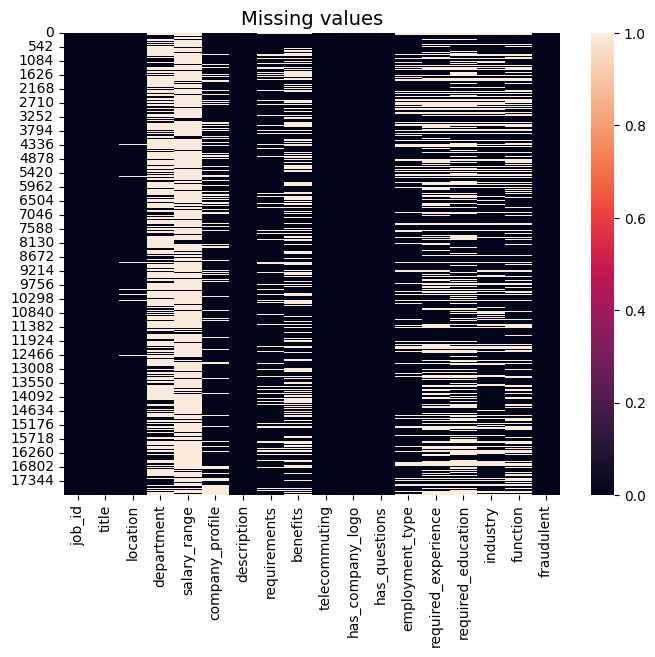

In [6]:
# Number of missing values in each column
plt.figure(figsize=(8,6))
sns.heatmap(df.isnull())
plt.title("Missing values", fontsize=14)
df.isna().sum()

<b>Observations: </b>
<br>
<br>
It is clear from the above visual that there are many missing values in:
- department
- salary_range
- benefits
- required_experience
- required_education
- industry
- function

In [7]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)                                            # Nu of zero in each column
        mis_val = df.isnull().sum()                                                                #Missing value in each column
        mis_val_percent = 100 * df.isnull().sum() / len(df)                                        #Missing value percent accross column
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)                         #Concatenation of above aoutput
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})               #Renaming of each coumn
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']  #column having total of zero value and missing values
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df) # Column having percentage of totalof zero and missing value
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(                                                     #Selecting and sorting those column which have at not a zero value in % of Total Values column
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(df)

Your selected dataframe has 18 columns and 17880 Rows.
There are 12 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
salary_range,0,15012,84.0,15012,84.0,object
department,0,11547,64.6,11547,64.6,object
required_education,0,8105,45.3,8105,45.3,object
benefits,0,7212,40.3,7212,40.3,object
required_experience,0,7050,39.4,7050,39.4,object
function,0,6455,36.1,6455,36.1,object
industry,0,4903,27.4,4903,27.4,object
employment_type,0,3471,19.4,3471,19.4,object
company_profile,0,3308,18.5,3308,18.5,object
requirements,0,2696,15.1,2696,15.1,object


In [8]:
# Dropping id and columns with too many missing values
df2 = df.drop(['salary_range', 'job_id', 'department', 'required_education', 'benefits'], axis=1, inplace=False)
df2.shape

(17880, 13)

In [9]:
df2.head()

,title,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,Other,Internship,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,Full-time,Not Applicable,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,Full-time,Mid-Senior level,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,Full-time,Mid-Senior level,Hospital & Health Care,Health Care Provider,0


Logically speaking, there is not likely much value in the columns "has_questions" and "employment_type", as fake postings could be of any employment type. 

When it comes to the questions, whether there are or aren't any isn't what would be valuable from this area, it would be the questions themselves, which are sadly not included in the dataset.

In [10]:
df3 = df2.drop(['employment_type', 'has_questions'], axis=1, inplace=False)
df3.head()

,title,location,company_profile,description,requirements,telecommuting,has_company_logo,required_experience,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,Internship,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,Not Applicable,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,Mid-Senior level,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,Mid-Senior level,Hospital & Health Care,Health Care Provider,0


In [11]:
# Checking number of rows with 1-12 missing values
for i in range(len(list(df2.columns.values))):
    data = df2[df2.isnull().sum(axis=1) == i]
    print(f"Number of rows with {i} missing value(s): {len(data.index)}")

Number of rows with 0 missing value(s): 7274
Number of rows with 1 missing value(s): 3459
Number of rows with 2 missing value(s): 2195
Number of rows with 3 missing value(s): 1421
Number of rows with 4 missing value(s): 1970
Number of rows with 5 missing value(s): 1143
Number of rows with 6 missing value(s): 403
Number of rows with 7 missing value(s): 15
Number of rows with 8 missing value(s): 0
Number of rows with 9 missing value(s): 0
Number of rows with 10 missing value(s): 0
Number of rows with 11 missing value(s): 0
Number of rows with 12 missing value(s): 0


In [12]:
# Taking only rows that aren't null in 'description'
df4 = df2[df2['description'].notna()]

In [13]:
# Replacing all missing values with "unknown"
for col in df4.columns.values:
    df4.loc[df4[col].isnull(), col] = "Unknown"

In [14]:
df4.isna().apply(pd.value_counts)

,title,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,industry,function,fraudulent
False,17879,17879,17879,17879,17879,17879,17879,17879,17879,17879,17879,17879,17879


In [15]:
df4.head(5)

,title,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,Other,Internship,Unknown,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,Full-time,Not Applicable,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,Unknown,Unknown,Unknown,Unknown,0
3,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,Full-time,Mid-Senior level,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,Full-time,Mid-Senior level,Hospital & Health Care,Health Care Provider,0


- It seems like it makes sense to go through EDA before going forward with dropping any more columns than we already have.

## Exploratory Data Analysis

In [16]:
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [17]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [18]:
def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

### Univariate Analysis

**telecommuting**

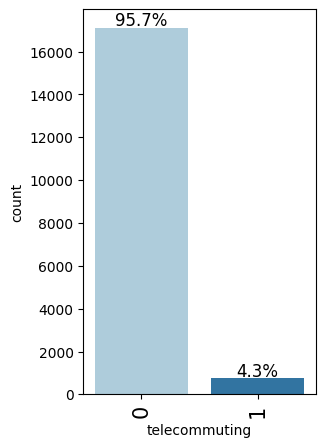

In [19]:
labeled_barplot(df4, 'telecommuting', perc=True)

<b>Observation:</b>
- The vast majority of postings involve a job that is not remote.

**has_company_logo**

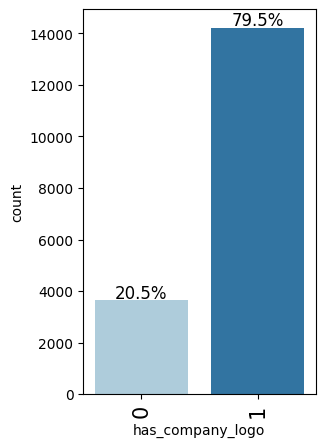

In [20]:
labeled_barplot(df4, 'has_company_logo', perc=True)

<b>Observation:</b>
- The vast majority of postings have a company logo.

**has_questions**

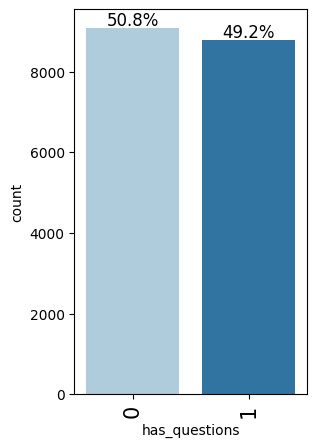

In [21]:
labeled_barplot(df4, 'has_questions', perc=True)

<b>Observation:</b>
- The data is almost evenly split, between postings with and without questions, meaning this is likely not a very telling column.

**employment_type**

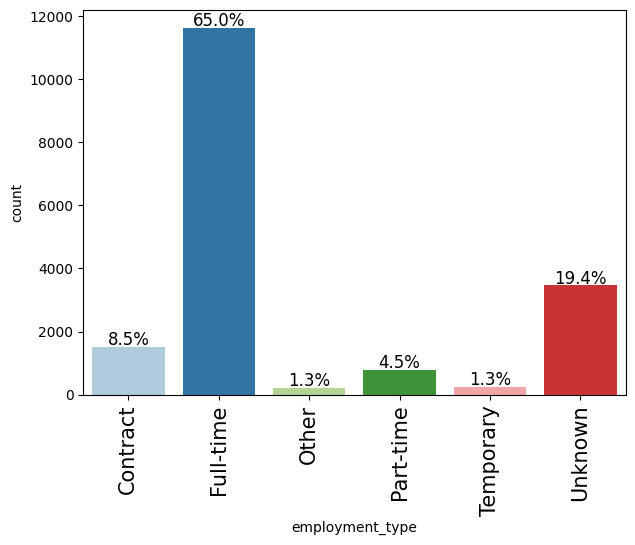

In [22]:
labeled_barplot(df4, 'employment_type', perc=True)

<b>Observation:</b>
- Most postings involve a job that is full-time, with the second most common being contract, then part-time.

**required_experience**

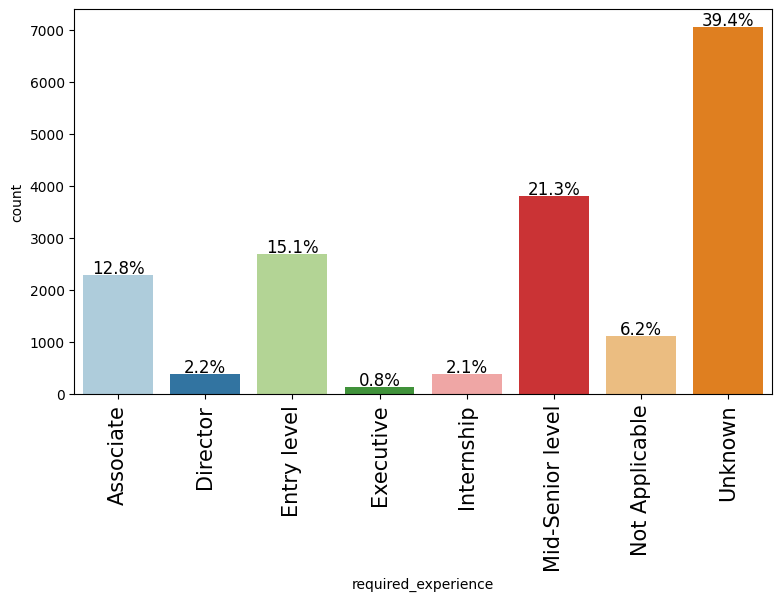

In [23]:
labeled_barplot(df4, 'required_experience', perc=True)

<b>Observation:</b>
- Most postings involve a job that had no required experience input.
- Second most common is mid-senior level, then entry-level, and associate.

**fraudulent**

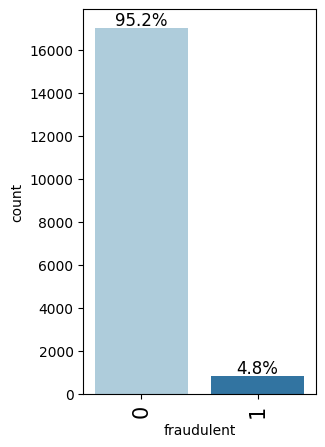

In [24]:
labeled_barplot(df4, 'fraudulent', perc=True)

<b>Observation:</b>
- Most postings involve a job that was not fraudulent.

### Bivariate Analysis

**telecommuting x target**

fraudulent         0    1    All
telecommuting                   
All            17014  865  17879
0              16311  801  17112
1                703   64    767
------------------------------------------------------------------------------------------------------------------------


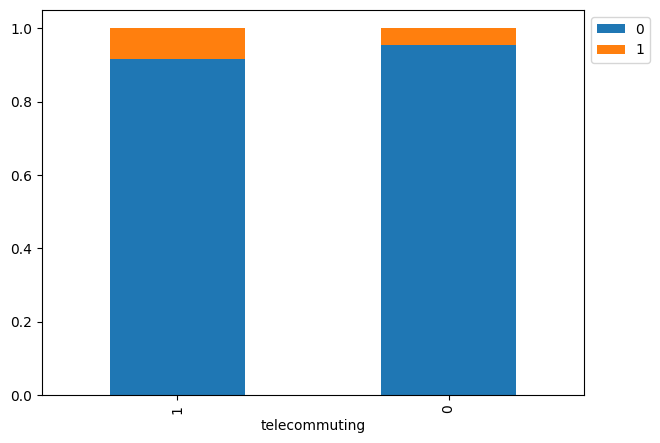

In [25]:
stacked_barplot(df4, 'telecommuting', 'fraudulent')

<b>Observation(s):</b>
<ul>
    <li>There is a noticably larger distribution of fraudulent postings among those that are listed as remote.</li>
</ul>

**has_company_logo x target**

fraudulent            0    1    All
has_company_logo                   
All               17014  865  17879
0                  3077  582   3659
1                 13937  283  14220
------------------------------------------------------------------------------------------------------------------------


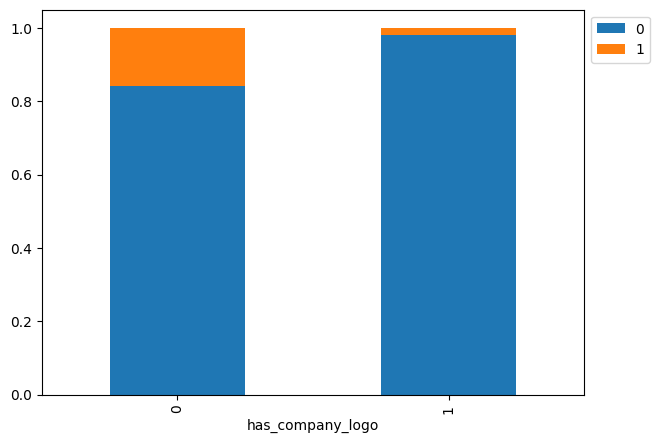

In [26]:
stacked_barplot(df4, 'has_company_logo', 'fraudulent')

<b>Observation(s):</b>
<ul>
    <li>There is a much larger distribution of fraudulent postings among those that do not have a company logo.</li>
</ul>

**has_questions x target**

fraudulent         0    1    All
has_questions                   
All            17014  865  17879
0               8472  615   9087
1               8542  250   8792
------------------------------------------------------------------------------------------------------------------------


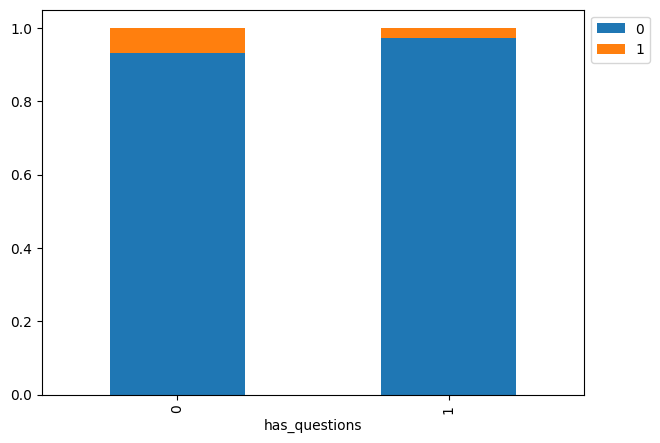

In [27]:
stacked_barplot(df4, 'has_questions', 'fraudulent')

<b>Observation(s):</b>
<ul>
    <li>There is a noticably larger distribution of fraudulent postings among those that don't have questions.</li>
</ul>

**employment_type x target**

fraudulent           0    1    All
employment_type                   
All              17014  865  17879
Full-time        11130  490  11620
Unknown           3230  240   3470
Part-time          723   74    797
Contract          1480   44   1524
Other              212   15    227
Temporary          239    2    241
------------------------------------------------------------------------------------------------------------------------


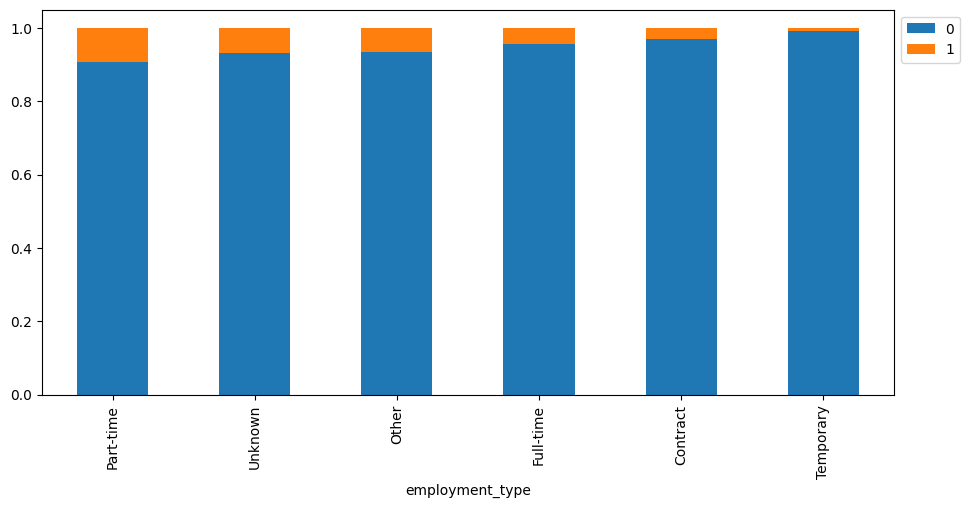

In [28]:
stacked_barplot(df4, 'employment_type', 'fraudulent')

<b>Observation(s):</b>
<ul>
    <li>Part-time is the most common employment type for fraudulent postings.</li>
    <li>Unknown is the second most common, followed by other and full-time.</li>
</ul>

**required_experience x target**

fraudulent               0    1    All
required_experience                   
All                  17014  865  17879
Unknown               6615  434   7049
Entry level           2518  179   2697
Mid-Senior level      3696  113   3809
Not Applicable        1056   60   1116
Associate             2255   42   2297
Director               372   17    389
Executive              131   10    141
Internship             371   10    381
------------------------------------------------------------------------------------------------------------------------


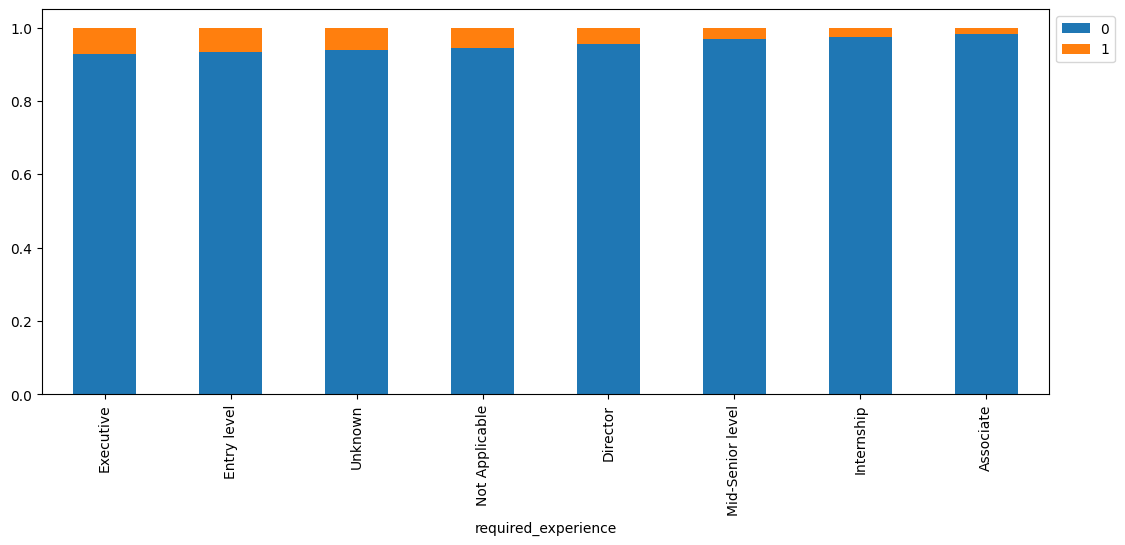

In [29]:
stacked_barplot(df4, 'required_experience', 'fraudulent')

<b>Observation(s):</b>
<ul>
    <li>Executive experience is the most common among fraudulent postings.</li>
    <li>Entry level is the second most common, followed by unknown and 'not applicable'.</li>
</ul>

**function x target**

fraudulent                  0    1    All
function                                 
All                     17014  865  17879
Unknown                  6118  336   6454
Administrative            511  119    630
Engineering              1235  113   1348
Customer Service         1162   67   1229
Sales                    1427   41   1468
Other                     293   32    325
Information Technology   1717   32   1749
Accounting/Auditing       183   29    212
Finance                   157   15    172
Business Development      215   13    228
Marketing                 820   10    830
Project Management        173   10    183
Human Resources           196    9    205
Management                311    6    317
Advertising                85    5     90
Financial Analyst          28    5     33
Data Analyst               78    4     82
Consulting                140    4    144
Distribution               21    3     24
Design                    337    3    340
Manufacturing              72    2

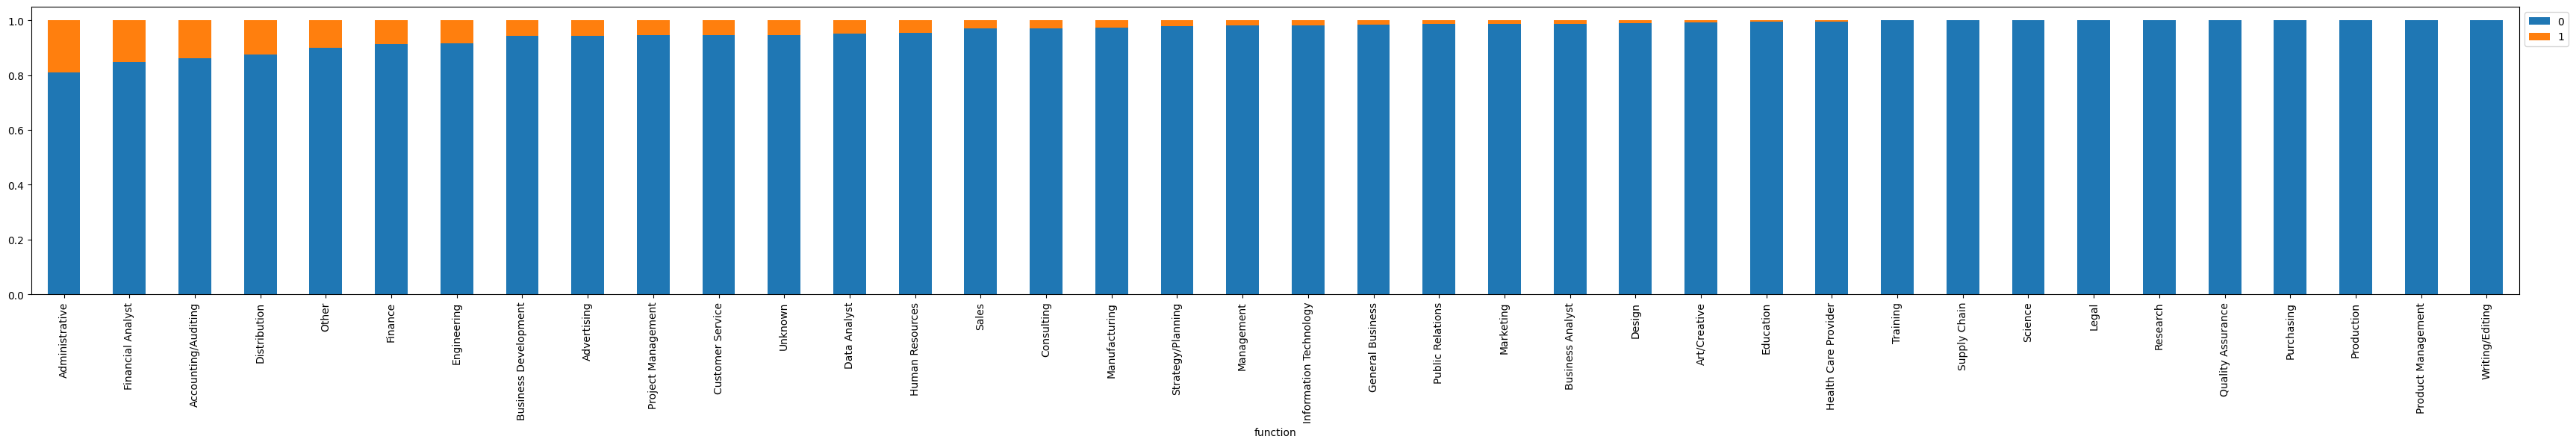

In [30]:
stacked_barplot(df4, 'function', 'fraudulent')

<b>Observation(s):</b>
<ul>
    <li>Unknown is the most common function among fraudulent postings.</li>
    <li>Administrative is the second most common, followed by engineering.</li>
</ul>

**industry x function**

fraudulent                               0    1    All
industry                                              
All                                  17014  865  17879
Unknown                               4628  274   4902
Oil & Energy                           178  109    287
Accounting                             102   57    159
Hospital & Health Care                 446   51    497
...                                    ...  ...    ...
Law Enforcement                         10    0     10
Investment Banking                       4    0      4
Internet                              1062    0   1062
International Trade and Development      8    0      8
Legal Services                          97    0     97

[133 rows x 3 columns]
------------------------------------------------------------------------------------------------------------------------


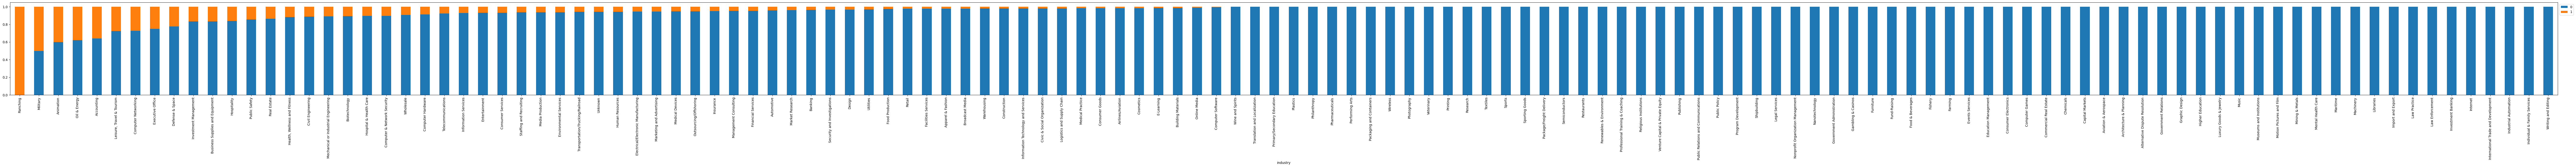

In [31]:
stacked_barplot(df4, 'industry', 'fraudulent')

<b>Observation(s):</b>
<ul>
    <li>Oil & Energy had the largest distribution of fraudulent postings, by far.</li>
    <li>Accounting had the second largest, followed by Hospital & Health Care</li>
</ul>

## Feature Engineering

In [32]:
df4.head()

,title,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,Other,Internship,Unknown,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,Full-time,Not Applicable,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,Unknown,Unknown,Unknown,Unknown,0
3,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,Full-time,Mid-Senior level,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,Full-time,Mid-Senior level,Hospital & Health Care,Health Care Provider,0


#### Title

In [33]:
# Number of unique values in the title column.
len(df4.title.unique())

11231

Sadly, this is not very helpful, so it will be dropped.

In [34]:
df5 = df4.drop('title', axis=1)

#### Location

In [35]:
# Number of unique values in the title column.
len(df5.location.unique())

3106

We want to extract only the unique countries and states for now, so that there aren't quite as many unique values.

In [36]:
df5['location'] = df4['location'].str.split(',').apply(lambda x: ','.join(x[:-1]))

In [37]:
# Number of unique values in the title column.
len(df5.location.unique())

529

That's still quite a few uniques, so let's take only the countries instead.

In [38]:
df5['location'] = df4['location'].str.split(',', expand=True)[0]

In [39]:
# Number of unique values in the title column.
len(df5.location.unique())

91

In [40]:
df5.head()

,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,industry,function,fraudulent
0,US,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,Other,Internship,Unknown,Marketing,0
1,NZ,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,Full-time,Not Applicable,Marketing and Advertising,Customer Service,0
2,US,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,Unknown,Unknown,Unknown,Unknown,0
3,US,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,Full-time,Mid-Senior level,Computer Software,Sales,0
4,US,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,Full-time,Mid-Senior level,Hospital & Health Care,Health Care Provider,0


Better

#### Employment Type

In [41]:
df5 = pd.get_dummies(df5, columns=['employment_type'], drop_first=True)

#### Required Experience

In [42]:
df5 = pd.get_dummies(df5, columns=['required_experience'], drop_first=True)

#### Industry & Function

Due to the large number of unique values in these two columns, they will be dropped to avoid increasing the dimensionality too heavily.

### De-contraction of words in text-heavy columns

In [43]:
#!pip install contractions
import contractions

In [44]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

# Perform the above operation over all the rows of tweet column of the dataframe.
for col in ['company_profile','description','requirements']:
    for i, row in df5.iterrows():
        content = df5.at[i, col]
        clean_content = replace_contractions(content)
        df5.at[i,col] = clean_content
df5.head()

,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,industry,function,fraudulent,...,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_experience_Unknown
0,US,"We are Food52, and we have created a groundbre...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,Unknown,Marketing,0,...,False,False,False,False,False,False,True,False,False,False
1,NZ,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,Marketing and Advertising,Customer Service,0,...,False,False,False,False,False,False,False,False,True,False
2,US,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,Unknown,Unknown,0,...,False,False,True,False,False,False,False,False,False,True
3,US,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,Computer Software,Sales,0,...,False,False,False,False,False,False,False,True,False,False
4,US,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RIGHT NOW license in the State ...,0,1,1,Hospital & Health Care,Health Care Provider,0,...,False,False,False,False,False,False,False,True,False,False


In [45]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\codyd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [46]:
import re

### Removal of numbers in text-heavy columns

In [47]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

for col in ['company_profile','description','requirements']:
    df5[col] = df5[col].apply(lambda x: remove_numbers(x))

In [48]:
df5.head()

,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,industry,function,fraudulent,...,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_experience_Unknown
0,US,"We are Food, and we have created a groundbreak...","Food, a fast-growing, James Beard Award-winnin...",Experience with content management systems a m...,0,1,0,Unknown,Marketing,0,...,False,False,False,False,False,False,True,False,False,False
1,NZ,"Seconds, the worlds Cloud Video Production Se...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,Marketing and Advertising,Customer Service,0,...,False,False,False,False,False,False,False,False,True,False
2,US,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,Unknown,Unknown,0,...,False,False,True,False,False,False,False,False,False,True
3,US,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,Computer Software,Sales,0,...,False,False,False,False,False,False,False,True,False,False
4,US,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RIGHT NOW license in the State ...,0,1,1,Hospital & Health Care,Health Care Provider,0,...,False,False,False,False,False,False,False,True,False,False


### Tokenization of text-heavy columns

In [49]:
for col in ['company_profile', 'description', 'requirements']:
    df5[col] = df5.apply(lambda row: nltk.word_tokenize(row[col]), axis=1)
df5.head()

,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,industry,function,fraudulent,...,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_experience_Unknown
0,US,"[We, are, Food, ,, and, we, have, created, a, ...","[Food, ,, a, fast-growing, ,, James, Beard, Aw...","[Experience, with, content, management, system...",0,1,0,Unknown,Marketing,0,...,False,False,False,False,False,False,True,False,False,False
1,NZ,"[Seconds, ,, the, worlds, Cloud, Video, Produc...","[Organised, -, Focused, -, Vibrant, -, Awesome...","[What, we, expect, from, you, :, Your, key, re...",0,1,0,Marketing and Advertising,Customer Service,0,...,False,False,False,False,False,False,False,False,True,False
2,US,"[Valor, Services, provides, Workforce, Solutio...","[Our, client, ,, located, in, Houston, ,, is, ...","[Implement, pre-commissioning, and, commission...",0,1,0,Unknown,Unknown,0,...,False,False,True,False,False,False,False,False,False,True
3,US,"[Our, passion, for, improving, quality, of, li...","[THE, COMPANY, :, ESRI, –, Environmental, Syst...","[EDUCATION, :, Bachelor, ’, s, or, Master, ’, ...",0,1,0,Computer Software,Sales,0,...,False,False,False,False,False,False,False,True,False,False
4,US,"[SpotSource, Solutions, LLC, is, a, Global, Hu...","[JOB, TITLE, :, Itemization, Review, ManagerLO...","[QUALIFICATIONS, :, RIGHT, NOW, license, in, t...",0,1,1,Hospital & Health Care,Health Care Provider,0,...,False,False,False,False,False,False,False,True,False,False


### Removing non-ascii characters from text-heavy columns

In [50]:
import unicodedata

In [51]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

In [52]:
for col in ['company_profile', 'description', 'requirements']:
    df5[col] = df5[col].apply(lambda x: remove_non_ascii(x))
df5.head()

,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,industry,function,fraudulent,...,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_experience_Unknown
0,US,"[We, are, Food, ,, and, we, have, created, a, ...","[Food, ,, a, fast-growing, ,, James, Beard, Aw...","[Experience, with, content, management, system...",0,1,0,Unknown,Marketing,0,...,False,False,False,False,False,False,True,False,False,False
1,NZ,"[Seconds, ,, the, worlds, Cloud, Video, Produc...","[Organised, -, Focused, -, Vibrant, -, Awesome...","[What, we, expect, from, you, :, Your, key, re...",0,1,0,Marketing and Advertising,Customer Service,0,...,False,False,False,False,False,False,False,False,True,False
2,US,"[Valor, Services, provides, Workforce, Solutio...","[Our, client, ,, located, in, Houston, ,, is, ...","[Implement, pre-commissioning, and, commission...",0,1,0,Unknown,Unknown,0,...,False,False,True,False,False,False,False,False,False,True
3,US,"[Our, passion, for, improving, quality, of, li...","[THE, COMPANY, :, ESRI, , Environmental, Syste...","[EDUCATION, :, Bachelor, , s, or, Master, , s,...",0,1,0,Computer Software,Sales,0,...,False,False,False,False,False,False,False,True,False,False
4,US,"[SpotSource, Solutions, LLC, is, a, Global, Hu...","[JOB, TITLE, :, Itemization, Review, ManagerLO...","[QUALIFICATIONS, :, RIGHT, NOW, license, in, t...",0,1,1,Hospital & Health Care,Health Care Provider,0,...,False,False,False,False,False,False,False,True,False,False


### Making text-heavy columns all lowercase

In [53]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

In [54]:
for col in ['company_profile', 'description', 'requirements']:
    df5[col] = df5[col].apply(lambda x: to_lowercase(x))
df5.head()

,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,industry,function,fraudulent,...,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_experience_Unknown
0,US,"[we, are, food, ,, and, we, have, created, a, ...","[food, ,, a, fast-growing, ,, james, beard, aw...","[experience, with, content, management, system...",0,1,0,Unknown,Marketing,0,...,False,False,False,False,False,False,True,False,False,False
1,NZ,"[seconds, ,, the, worlds, cloud, video, produc...","[organised, -, focused, -, vibrant, -, awesome...","[what, we, expect, from, you, :, your, key, re...",0,1,0,Marketing and Advertising,Customer Service,0,...,False,False,False,False,False,False,False,False,True,False
2,US,"[valor, services, provides, workforce, solutio...","[our, client, ,, located, in, houston, ,, is, ...","[implement, pre-commissioning, and, commission...",0,1,0,Unknown,Unknown,0,...,False,False,True,False,False,False,False,False,False,True
3,US,"[our, passion, for, improving, quality, of, li...","[the, company, :, esri, , environmental, syste...","[education, :, bachelor, , s, or, master, , s,...",0,1,0,Computer Software,Sales,0,...,False,False,False,False,False,False,False,True,False,False
4,US,"[spotsource, solutions, llc, is, a, global, hu...","[job, title, :, itemization, review, managerlo...","[qualifications, :, right, now, license, in, t...",0,1,1,Hospital & Health Care,Health Care Provider,0,...,False,False,False,False,False,False,False,True,False,False


### Removing punctuation from text-heavy columns

In [55]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words

In [56]:
for col in ['company_profile', 'description', 'requirements']:
    df5[col] = df5[col].apply(lambda x: remove_punctuation(x))
df5.head()

,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,industry,function,fraudulent,...,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_experience_Unknown
0,US,"[we, are, food, and, we, have, created, a, gro...","[food, a, fastgrowing, james, beard, awardwinn...","[experience, with, content, management, system...",0,1,0,Unknown,Marketing,0,...,False,False,False,False,False,False,True,False,False,False
1,NZ,"[seconds, the, worlds, cloud, video, productio...","[organised, focused, vibrant, awesome, do, you...","[what, we, expect, from, you, your, key, respo...",0,1,0,Marketing and Advertising,Customer Service,0,...,False,False,False,False,False,False,False,False,True,False
2,US,"[valor, services, provides, workforce, solutio...","[our, client, located, in, houston, is, active...","[implement, precommissioning, and, commissioni...",0,1,0,Unknown,Unknown,0,...,False,False,True,False,False,False,False,False,False,True
3,US,"[our, passion, for, improving, quality, of, li...","[the, company, esri, environmental, systems, r...","[education, bachelor, s, or, master, s, in, gi...",0,1,0,Computer Software,Sales,0,...,False,False,False,False,False,False,False,True,False,False
4,US,"[spotsource, solutions, llc, is, a, global, hu...","[job, title, itemization, review, managerlocat...","[qualifications, right, now, license, in, the,...",0,1,1,Hospital & Health Care,Health Care Provider,0,...,False,False,False,False,False,False,False,True,False,False


### Removing stopwords from text-heavy columns

In [57]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\codyd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator           # Used for plotting the wordcloud of a corpus
import nltk                                                               # Used for different task of NLP
from nltk.corpus import stopwords

In [59]:
stopwords = stopwords.words('english')

In [60]:
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        if word not in stopwords:
            new_words.append(word)        # Append processed words to new list.
    return new_words

In [61]:
for col in ['company_profile', 'description', 'requirements']:
    df5[col] = df5[col].apply(lambda x: remove_stopwords(x))
df5.head()

,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,industry,function,fraudulent,...,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_experience_Unknown
0,US,"[food, created, groundbreaking, awardwinning, ...","[food, fastgrowing, james, beard, awardwinning...","[experience, content, management, systems, maj...",0,1,0,Unknown,Marketing,0,...,False,False,False,False,False,False,True,False,False,False
1,NZ,"[seconds, worlds, cloud, video, production, se...","[organised, focused, vibrant, awesome, passion...","[expect, key, responsibility, communicate, cli...",0,1,0,Marketing and Advertising,Customer Service,0,...,False,False,False,False,False,False,False,False,True,False
2,US,"[valor, services, provides, workforce, solutio...","[client, located, houston, actively, seeking, ...","[implement, precommissioning, commissioning, p...",0,1,0,Unknown,Unknown,0,...,False,False,True,False,False,False,False,False,False,True
3,US,"[passion, improving, quality, life, geography,...","[company, esri, environmental, systems, resear...","[education, bachelor, master, gis, business, a...",0,1,0,Computer Software,Sales,0,...,False,False,False,False,False,False,False,True,False,False
4,US,"[spotsource, solutions, llc, global, human, ca...","[job, title, itemization, review, managerlocat...","[qualifications, right, license, state, texasd...",0,1,1,Hospital & Health Care,Health Care Provider,0,...,False,False,False,False,False,False,False,True,False,False


### Lemmatization of text-heavy columns

In [62]:
from nltk.stem.wordnet import WordNetLemmatizer    

In [63]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\codyd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [64]:
lemmatizer = WordNetLemmatizer()

In [65]:
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word))
    return new_words

In [66]:
for col in ['company_profile', 'description', 'requirements']:
    df5[col] = df5[col].apply(lambda x: lemmatize_list(x))
df5.head()

,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,industry,function,fraudulent,...,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_experience_Unknown
0,US,"[food, created, groundbreaking, awardwinning, ...","[food, fastgrowing, james, beard, awardwinning...","[experience, content, management, system, majo...",0,1,0,Unknown,Marketing,0,...,False,False,False,False,False,False,True,False,False,False
1,NZ,"[second, world, cloud, video, production, serv...","[organised, focused, vibrant, awesome, passion...","[expect, key, responsibility, communicate, cli...",0,1,0,Marketing and Advertising,Customer Service,0,...,False,False,False,False,False,False,False,False,True,False
2,US,"[valor, service, provides, workforce, solution...","[client, located, houston, actively, seeking, ...","[implement, precommissioning, commissioning, p...",0,1,0,Unknown,Unknown,0,...,False,False,True,False,False,False,False,False,False,True
3,US,"[passion, improving, quality, life, geography,...","[company, esri, environmental, system, researc...","[education, bachelor, master, gi, business, ad...",0,1,0,Computer Software,Sales,0,...,False,False,False,False,False,False,False,True,False,False
4,US,"[spotsource, solution, llc, global, human, cap...","[job, title, itemization, review, managerlocat...","[qualification, right, license, state, texasdi...",0,1,1,Hospital & Health Care,Health Care Provider,0,...,False,False,False,False,False,False,False,True,False,False


In [67]:
# Leaving for future iterations
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

#### Most common words in each text-heavy column

In [68]:
from collections import Counter   

#### Company Profile

In [69]:
top = Counter([item for sublist in df5['company_profile'] for item in sublist])
freq = pd.DataFrame(top.most_common(20))
freq.columns = ['Common_words','count']
freq.style.background_gradient(cmap='Reds')

,Common_words,count
0,company,11166
1,service,9526
2,team,8045
3,work,7287
4,business,6610
5,people,6393
6,solution,6054
7,customer,5581
8,client,5543
9,u,5296


#### Description

In [70]:
top = Counter([item for sublist in df5['description'] for item in sublist])
freq = pd.DataFrame(top.most_common(20))
freq.columns = ['Common_words','count']
freq.style.background_gradient(cmap='Reds')

,Common_words,count
0,team,20259
1,work,15190
2,customer,14886
3,service,12439
4,company,11629
5,product,11468
6,business,11465
7,client,11058
8,experience,10577
9,new,9714


#### Requirements

In [71]:
top = Counter([item for sublist in df5['requirements'] for item in sublist])
freq = pd.DataFrame(top.most_common(20))
freq.columns = ['Common_words','count']
freq.style.background_gradient(cmap='Reds')

,Common_words,count
0,experience,22370
1,skill,11679
2,work,9971
3,year,9439
4,ability,7633
5,knowledge,6326
6,communication,6065
7,team,5380
8,required,5218
9,degree,4902


In [72]:
df5.head()

,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,industry,function,fraudulent,...,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_experience_Unknown
0,US,"[food, created, groundbreaking, awardwinning, ...","[food, fastgrowing, james, beard, awardwinning...","[experience, content, management, system, majo...",0,1,0,Unknown,Marketing,0,...,False,False,False,False,False,False,True,False,False,False
1,NZ,"[second, world, cloud, video, production, serv...","[organised, focused, vibrant, awesome, passion...","[expect, key, responsibility, communicate, cli...",0,1,0,Marketing and Advertising,Customer Service,0,...,False,False,False,False,False,False,False,False,True,False
2,US,"[valor, service, provides, workforce, solution...","[client, located, houston, actively, seeking, ...","[implement, precommissioning, commissioning, p...",0,1,0,Unknown,Unknown,0,...,False,False,True,False,False,False,False,False,False,True
3,US,"[passion, improving, quality, life, geography,...","[company, esri, environmental, system, researc...","[education, bachelor, master, gi, business, ad...",0,1,0,Computer Software,Sales,0,...,False,False,False,False,False,False,False,True,False,False
4,US,"[spotsource, solution, llc, global, human, cap...","[job, title, itemization, review, managerlocat...","[qualification, right, license, state, texasdi...",0,1,1,Hospital & Health Care,Health Care Provider,0,...,False,False,False,False,False,False,False,True,False,False


## **Model Building - Iteration 1**

### **Random Forest w/o content**

In [73]:
X = df5.drop(['fraudulent', 'location', 'company_profile', 'description', 'requirements', 'industry', 'function'], axis=1)
X = X.astype(bool)
y = df5['fraudulent']
y = y.astype(bool)

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [76]:
# function to compute different metrics to check performance of a regression model
def saveTestResults(model, pred, target, data, modelName, isTrain: bool):

    # predicting using the independent variables
    precision = precision_score(target, pred)
    recall = recall_score(target, pred)
    f1 = f1_score(target, pred)
    accuracy = accuracy_score(target, pred)

    df_perf = pd.DataFrame(
        {
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Accuracy": accuracy
        },
        index=[0],
    )
    
    # Storing results 
    if isTrain == False:
        data['Model'].append(modelName)
        data['Precision'].append(precision)
        data['Recall'].append(recall)
        data['F1 Score'].append(f1)
        data['Accuracy'].append(accuracy)    

    return df_perf

In [77]:
def getBestThreshold(model, pred, target, data, modelName):
    '''Function to compute optimal prediction threshold for given model'''
    
    # Get predicted probabilities for the positive class
    baseProbs = model.predict_proba(pred)[:, 1]
    
    threshold = 0.3
    
    results = {
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Accuracy': []
    }
    
    while True:
        customPred = (baseProbs >= threshold).astype(int)

        res = saveTestResults(model, customPred, target, data, modelName, isTrain=True)
        results['Precision'].append((res['Precision'][0], threshold))
        results['Recall'].append((res['Recall'][0], threshold))
        results['F1 Score'].append((res['F1 Score'][0], threshold))
        results['Accuracy'].append((res['Accuracy'][0], threshold))

        if threshold >= 0.99:
            break
        else:
            threshold = round(threshold + 0.01, 2)
            continue

    for key, value in results.items():
        results[key] = max(value)
    
    return results

In [78]:
def get_weights(model):
    '''Scores various combinations of class weights and outputs the results, 
    along with the strongest pair'''
    custom_weights = {0: 0.1, 1: 2}

    best_weights = {0: 0.1, 1: 2}
    best_score = 0
    
    results = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Accuracy': []
    }
    for i in range(20):
        model.set_params(class_weight=custom_weights)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if len(results['F1 Score']) >= 2:
            try:
                if results['F1 Score'][-2] > results['F1 Score'][-1]:
                    best_weights[0] = float(results['Model'][-2].split(':')[0])
                    best_weights[1] = float(results['Model'][-2].split(':')[1])
                    best_score = results['F1 Score'][-2]
                    break
            except IndexError as e:
                print(e)
        
        custom_weights[0] = round(custom_weights[0] + 0.1, 1)
        custom_weights[1] = round(custom_weights[1] - 0.1, 1)

    while True:
        custom_weights[0] = round(custom_weights[0] + 0.1, 1)
        model.set_params(class_weight=custom_weights)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if best_score > results['F1 Score'][-1]:
            custom_weights[0] = best_weights[0]
            break
        elif best_score < results['F1 Score'][-1]:
            best_score = results['F1 Score'][-1]
            best_weights[0] = custom_weights[0]

    while True:
        custom_weights[0] = round(custom_weights[0] - 0.1, 1)
        model.set_params(class_weight=custom_weights)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if best_score > results['F1 Score'][-1]:
            custom_weights[0] = best_weights[0]
            break
        elif best_score < results['F1 Score'][-1]:
            best_score = results['F1 Score'][-1]
            best_weights[0] = custom_weights[0]

    while True:
        custom_weights[1] = round(custom_weights[1] + 0.1, 1)
        model.set_params(class_weight=custom_weights)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if best_score > results['F1 Score'][-1]:
            custom_weights[1] = best_weights[1]
            break
        elif best_score < results['F1 Score'][-1]:
            best_score = results['F1 Score'][-1]
            best_weights[1] = custom_weights[1]

    while True:
        custom_weights[1] = round(custom_weights[1] - 0.1, 1)
        model.set_params(class_weight=custom_weights)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if best_score > results['F1 Score'][-1]:
            custom_weights[1] = best_weights[1]
            break
        elif best_score < results['F1 Score'][-1]:
            best_score = results['F1 Score'][-1]
            best_weights[1] = custom_weights[1]
    
    return results

In [79]:
resultsDict1 = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Accuracy': []
}

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [81]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

trainPred = rf.predict(X_train)
rfNoContentTrain = saveTestResults(rf, trainPred, y_train, resultsDict1, "RandomForest w/o Content", isTrain=True)
rfNoContentTrain

,Precision,Recall,F1 Score,Accuracy
0,0.808219,0.097521,0.174041,0.955254


In [82]:
testPred = rf.predict(X_test)
rfNoContentTest = saveTestResults(rf, testPred, y_test, resultsDict1, "RandomForest w/o Content", isTrain=False)
rfNoContentTest

,Precision,Recall,F1 Score,Accuracy
0,0.625,0.076923,0.136986,0.95302


### Refinement

#### Prediction Threshold

In [83]:
# Getting best prediction threshold for test set
warnings.filterwarnings('ignore')
optimized = getBestThreshold(rf, X_test, y_test, resultsDict1, "RandomForest w/o Content")
warnings.filterwarnings('default')
optimized

{'Precision': (1.0, 0.99),
 'Recall': (0.18461538461538463, 0.31),
 'F1 Score': (0.2302158273381295, 0.31),
 'Accuracy': (0.9543251304996272, 0.72)}

- We'll try both 0.31 and 0.71

In [84]:
baseProb = rf.predict_proba(X_test)[:, 1]
threshold = 0.31
customPred = (baseProb >= threshold).astype(int)

thresh1Results = saveTestResults(rf, customPred, y_test, resultsDict1, "RandomForest NoCon 0.31", isTrain=False)
thresh1Results

C:\Users\codyd\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\codyd\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


,Precision,Recall,F1 Score,Accuracy
0,0.305732,0.184615,0.230216,0.940157


In [85]:
baseProb = rf.predict_proba(X_test)[:, 1]
threshold = 0.71
customPred = (baseProb >= threshold).astype(int)

thresh2Results = saveTestResults(rf, customPred, y_test, resultsDict1, "RandomForest NoCon 0.31", isTrain=False)
thresh2Results

C:\Users\codyd\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\codyd\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


,Precision,Recall,F1 Score,Accuracy
0,0.8,0.076923,0.140351,0.954325


#### Randomized Search Optimization

In [86]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

params = {
    'n_estimators': randint(100, 1000),  # Number of trees in the forest
    'max_depth': randint(5, 50),          # Maximum depth of each tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20),   # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]            # Whether bootstrap samples are used when building trees
}

In [87]:
search = RandomizedSearchCV(estimator=rf, param_distributions=params, n_iter=100,
                           random_state=42)
warnings.filterwarnings('ignore')
search.fit(X_train, y_train)
warnings.filterwarnings('default')

print("Best Params: ", search.best_params_)

Best Params:  {'bootstrap': True, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 19, 'n_estimators': 487}


In [87]:
#optimizedRF = search.best_estimator_
warnings.filterwarnings('ignore')
optimizedRF = RandomForestClassifier(bootstrap=True, max_depth=25, max_features='sqrt', 
                                     min_samples_leaf=7, min_samples_split=19, n_estimators=487,
                                     n_jobs=-1)
optimizedRF.fit(X_train, y_train)
pred = optimizedRF.predict(X_test)

randomizedNoConResults = saveTestResults(optimizedRF, pred, y_test, resultsDict1, "RandomForest NoCon Rand", isTrain=False)
randomizedNoConResults

,Precision,Recall,F1 Score,Accuracy
0,0.818182,0.069231,0.12766,0.954139


#### Class Weight

**Balanced**

In [88]:
#best_params = search.best_params_
#searchRF_model = RandomForestClassifier(**best_params)

optimizedRF.set_params(class_weight='balanced')
optimizedRF.fit(X_train, y_train)

pred = optimizedRF.predict(X_test)

weightResultsRF = saveTestResults(optimizedRF, pred, y_test, resultsDict1, "RandomForest NoCon RS", isTrain=True)
weightResultsRF

,Precision,Recall,F1 Score,Accuracy
0,0.180905,0.692308,0.286853,0.833147


- Using 'balanced' was an improvement in F1, but a setback everywhere else, so let's try using custom weights.

**Custom**

In [89]:
weightResultsRFCus = get_weights(optimizedRF)

In [90]:
weightResultsRFCus2 = pd.DataFrame(weightResultsRFCus)
weightResultsRFCus2

,Model,Precision,Recall,F1 Score,Accuracy
0,0.1:2,0.151639,0.711538,0.250000,0.793065
1,0.2:1.9,0.201422,0.653846,0.307971,0.857569
2,0.3:1.8,0.311346,0.453846,0.369327,0.924870
3,0.4:1.7,0.316832,0.369231,0.341030,0.930835
4,0.5:1.7,0.316832,0.369231,0.341030,0.930835
5,0.2:1.7,0.201661,0.653846,0.308250,0.857755
6,0.3:1.8,0.310992,0.446154,0.366509,0.925242
7,0.3:1.7,0.312997,0.453846,0.370487,0.925242
8,0.3:1.6,0.305882,0.400000,0.346667,0.926920


- The weights with the strongest F1 score are 0.3 : 1.7, so that is what we will use going forward.

#### Re-evaluating threshold

Since every parameter for the model is presumably different than they were when the threshold was optimized the first time, it will need to be optimized again with this in mind.

In [92]:
optimizedRF.set_params(class_weight={0: 0.3, 1: 1.7})
optimizedRF.fit(X_train, y_train)

optimized2 = getBestThreshold(optimizedRF, X_test, y_test, resultsDict1, "RandomForest NoCon")
optimized2

{'Precision': (1.0, 0.85),
 'Recall': (0.6730769230769231, 0.31),
 'F1 Score': (0.3704866562009419, 0.48),
 'Accuracy': (0.9541387024608501, 0.83)}

In [93]:
baseProb = optimizedRF.predict_proba(X_test)[:, 1]
threshold = 0.48
customPred = (baseProb >= threshold).astype(int)

threshResults3 = saveTestResults(optimizedRF, customPred, y_test, resultsDict1, "RandomForest NoCon", isTrain=False)
threshResults3

,Precision,Recall,F1 Score,Accuracy
0,0.312997,0.453846,0.370487,0.925242


In [94]:
bestVersion = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Accuracy': []
}
bestVersion['Model'].append("RandomForest NoCon Iteration 1")
bestVersion['Precision'].append(threshResults3['Precision'][0])
bestVersion['Recall'].append(threshResults3['Recall'][0])
bestVersion['F1 Score'].append(threshResults3['F1 Score'][0])
bestVersion['Accuracy'].append(threshResults3['Accuracy'][0])

### **Random Forest w/ content**

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [84]:
df5.head()

,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,industry,function,fraudulent,...,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_experience_Unknown
0,US,"[food, created, groundbreaking, awardwinning, ...","[food, fastgrowing, james, beard, awardwinning...","[experience, content, management, system, majo...",0,1,0,Unknown,Marketing,0,...,False,False,False,False,False,False,True,False,False,False
1,NZ,"[second, world, cloud, video, production, serv...","[organised, focused, vibrant, awesome, passion...","[expect, key, responsibility, communicate, cli...",0,1,0,Marketing and Advertising,Customer Service,0,...,False,False,False,False,False,False,False,False,True,False
2,US,"[valor, service, provides, workforce, solution...","[client, located, houston, actively, seeking, ...","[implement, precommissioning, commissioning, p...",0,1,0,Unknown,Unknown,0,...,False,False,True,False,False,False,False,False,False,True
3,US,"[passion, improving, quality, life, geography,...","[company, esri, environmental, system, researc...","[education, bachelor, master, gi, business, ad...",0,1,0,Computer Software,Sales,0,...,False,False,False,False,False,False,False,True,False,False
4,US,"[spotsource, solution, llc, global, human, cap...","[job, title, itemization, review, managerlocat...","[qualification, right, license, state, texasdi...",0,1,1,Hospital & Health Care,Health Care Provider,0,...,False,False,False,False,False,False,False,True,False,False


In [85]:
df6 = df5.copy()
df6.drop(['function', 'industry', 'location'], axis=1, inplace=True)

In [86]:
for col in ['company_profile', 'description', 'requirements']:
    df6[col] = df6[col].astype(pd.StringDtype())

In [87]:
# Combine the lists from three columns into one column
df6['content'] = df6.apply(lambda row: row['company_profile'] + row['description'] + row['requirements'], axis=1)
df6.drop(['company_profile', 'description', 'requirements'], axis=1, inplace=True)

In [88]:
df6.head()

,telecommuting,has_company_logo,has_questions,fraudulent,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_experience_Unknown,content
0,0,1,0,0,False,True,False,False,False,False,False,False,True,False,False,False,"['food', 'created', 'groundbreaking', 'awardwi..."
1,0,1,0,0,True,False,False,False,False,False,False,False,False,False,True,False,"['second', 'world', 'cloud', 'video', 'product..."
2,0,1,0,0,False,False,False,False,True,False,False,False,False,False,False,True,"['valor', 'service', 'provides', 'workforce', ..."
3,0,1,0,0,True,False,False,False,False,False,False,False,False,True,False,False,"['passion', 'improving', 'quality', 'life', 'g..."
4,0,1,1,0,True,False,False,False,False,False,False,False,False,True,False,False,"['spotsource', 'solution', 'llc', 'global', 'h..."


In [89]:
bow_vector = CountVectorizer(max_features=3000)
feature = bow_vector.fit_transform(df6['content'])
feature = feature.toarray()

In [90]:
df6['fraudulent'] = df6['fraudulent'].astype(bool)
label = df6['fraudulent']

In [91]:
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.3, random_state=42)

In [92]:
warnings.filterwarnings('ignore')
rfCon = RandomForestClassifier(random_state=42, n_jobs=-1)
rfCon = rfCon.fit(X_train, y_train)

In [93]:
trainPred = rfCon.predict(X_train)

In [94]:
rfContentResultsTrain = saveTestResults(rfCon, trainPred, y_train, resultsDict1, "RandomForest w/ Con", isTrain=True)
rfContentResultsTrain

,Precision,Recall,F1 Score,Accuracy
0,1.0,1.0,1.0,1.0


In [95]:
testPred = rfCon.predict(X_test)
rfContentResultsTest = saveTestResults(rfCon, testPred, y_test, resultsDict1, "RandomForest w/ Content", isTrain=False)
rfContentResultsTest

,Precision,Recall,F1 Score,Accuracy
0,1.0,0.592308,0.743961,0.980239


### Refinement

#### Prediction Threshold

In [96]:
optimizedCon = getBestThreshold(rfCon, X_test, y_test, resultsDict1, "RandomForest w/ Content")
optimizedCon

{'Precision': (1.0, 0.99),
 'Recall': (0.6884615384615385, 0.31),
 'F1 Score': (0.8081264108352144, 0.31),
 'Accuracy': (0.9841536167039523, 0.32)}

- Again, we're targeting F1, so we'll try with 0.31

In [97]:
baseProb = rfCon.predict_proba(X_test)[:, 1]
threshold = 0.31
customPred = (baseProb >= threshold).astype(int)

threshConResults = saveTestResults(rfCon, customPred, y_test, resultsDict1, "RandomForest Con0.4", isTrain=False)
threshConResults

,Precision,Recall,F1 Score,Accuracy
0,0.978142,0.688462,0.808126,0.984154


- Significant improvement in all metrics, aside from precision.

In [98]:
bestVersion = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Accuracy': []
}
bestVersion['Model'].append("RandomForest Con Iteration 1")
bestVersion['Precision'].append(threshConResults['Precision'][0])
bestVersion['Recall'].append(threshConResults['Recall'][0])
bestVersion['F1 Score'].append(threshConResults['F1 Score'][0])
bestVersion['Accuracy'].append(threshConResults['Accuracy'][0])

In [99]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

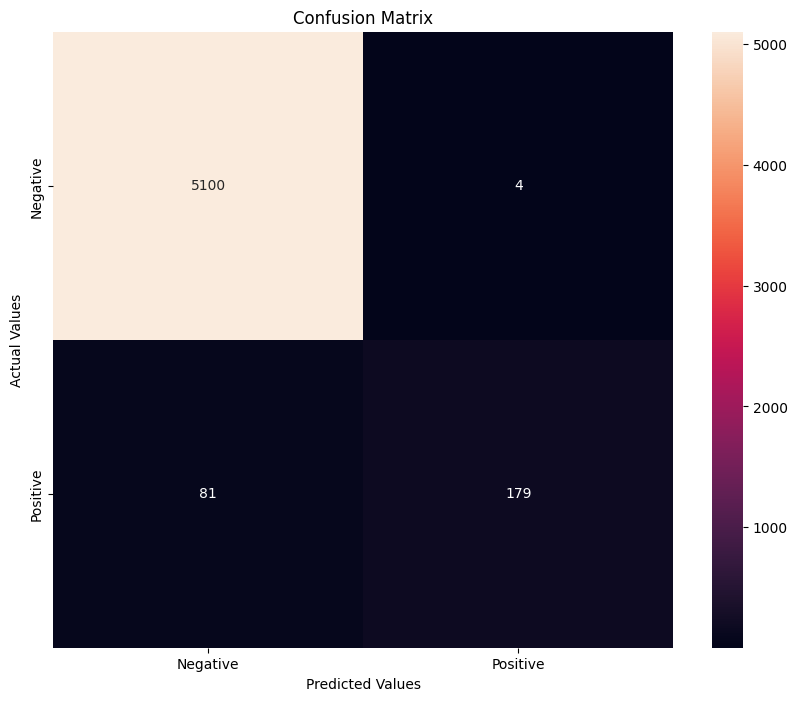

In [100]:
matrix = confusion_matrix(y_test, customPred)

matrix = pd.DataFrame(matrix, index=['Negative', 'Positive'],
                              columns=['Negative', 'Positive'])

plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#### Randomized Search Optimization

In [101]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

params = {
    'n_estimators': randint(50, 500),  # Number of trees in the forest
    'max_depth': randint(5, 50),          # Maximum depth of each tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20),   # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]            # Whether bootstrap samples are used when building trees
}

In [102]:
#search = RandomizedSearchCV(estimator=rfCon, param_distributions=params, n_iter=100,
#                           random_state=42)
#search.fit(X_train, y_train)
#print("Best Params: ", search.best_params_)

In [103]:
best_params = {'bootstrap': False, 'max_depth': 49, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 238}

In [104]:
#optimizedRFCon = search.best_estimator_
#pred = optimizedRFCon.predict(X_test)
optimizedRFCon = RandomForestClassifier(random_state=42, n_jobs=-1)
optimizedRFCon.set_params(bootstrap=False, max_depth=49, max_features='sqrt', min_samples_leaf=1,
                          min_samples_split=17, n_estimators=238)

RandomForestClassifier(bootstrap=False, max_depth=49, min_samples_split=17,
                       n_estimators=238, n_jobs=-1, random_state=42)

In [105]:
optimizedRFCon.fit(X_train, y_train)
y_pred = optimizedRFCon.predict(X_test)

In [106]:
randomizedConResults = saveTestResults(optimizedRFCon, y_pred, y_test, resultsDict1, "RandomForest Con RS", isTrain=False)
randomizedConResults

,Precision,Recall,F1 Score,Accuracy
0,1.0,0.526923,0.690176,0.977069


#### Class Weight

In [107]:
#best_params = search.best_params_
#searchRFCon = RandomForestClassifier(**best_params)

#searchRFCon.set_params(class_weight='balanced', random_state=42, n_jobs=-1)
#searchRFCon.fit(X_train, y_train)
searchRFCon = RandomForestClassifier(random_state=42, n_jobs=-1)
searchRFCon.set_params(bootstrap=False, max_depth=49, max_features='sqrt', min_samples_leaf=1,
                          min_samples_split=17, n_estimators=238, class_weight='balanced')

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=49,
                       min_samples_split=17, n_estimators=238, n_jobs=-1,
                       random_state=42)

In [108]:
searchRFCon.fit(X_train, y_train)
y_pred = searchRFCon.predict(X_test)

In [109]:
pred = searchRFCon.predict(X_test)
weightConResults = saveTestResults(searchRFCon, pred, y_test, resultsDict1, "RandomForest Con RS W", isTrain=False)
weightConResults

,Precision,Recall,F1 Score,Accuracy
0,0.673684,0.738462,0.704587,0.969985


In [110]:
matrix = confusion_matrix(y_test, pred)
matrix = pd.DataFrame(matrix, index=['Negative', 'Positive'],
                              columns=['Negative', 'Positive'])
print(matrix)

          Negative  Positive
Negative      5011        93
Positive        68       192


- Slight improvement, but sacrifices a lot on precision, so let's try with custom weights.

In [111]:
weightResultsCon = get_weights(searchRFCon)

In [112]:
weightResultsCon2 = pd.DataFrame(weightResultsCon)
weightResultsCon2

,Model,Precision,Recall,F1 Score,Accuracy
0,0.1:2,0.666667,0.730769,0.697248,0.969239
1,0.2:1.9,0.876238,0.680769,0.766234,0.979866
2,0.3:1.8,0.988095,0.638462,0.775701,0.982103
3,0.4:1.7,1.000000,0.619231,0.764846,0.981544
4,0.5:1.7,1.000000,0.615385,0.761905,0.981357
5,0.2:1.7,0.925134,0.665385,0.774049,0.981171
6,0.3:1.8,0.988095,0.638462,0.775701,0.982103
7,0.3:1.9,0.976331,0.634615,0.769231,0.981544
8,0.3:1.7,0.987952,0.630769,0.769953,0.981730


- The best weights are the same (0.3 : 1.8), regardless of whether or not content is included in the data given to the model, so that is what we will move forward with.

#### Re-evaluating Threshold

- Just like we did previously, we need to make sure we are using the optimal threshold for the new parameters.

In [113]:
#optimizedRFCon = RandomForestClassifier(**best_params)
#optimizedRFCon.set_params(class_weight={0: 0.3, 1: 1.7}, random_state=42)
#optimizedRFCon.fit(X_train, y_train)
optimizedRFCon = RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=False, max_depth=49, 
                                        max_features='sqrt', min_samples_leaf=1, min_samples_split=17, 
                                        n_estimators=238, class_weight={0: 0.3, 1: 1.8})
optimizedRFCon.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight={0: 0.3, 1: 1.8},
                       max_depth=49, min_samples_split=17, n_estimators=238,
                       n_jobs=-1, random_state=42)

In [114]:
bestThresh = getBestThreshold(optimizedRFCon, X_test, y_test, resultsDict1, "RandomForest Con")
bestThresh

{'Precision': (1.0, 0.99),
 'Recall': (0.7961538461538461, 0.3),
 'F1 Score': (0.8031809145129225, 0.32),
 'Accuracy': (0.9832214765100671, 0.42)}

- 0.32 seems to be optimal for F1, so that's what we will move on with.

In [115]:
baseProb = optimizedRFCon.predict_proba(X_test)[:, 1]
threshold = 0.32
customPred = (baseProb >= threshold).astype(int)

optimizedThreshResults = saveTestResults(optimizedRFCon, customPred, y_test, resultsDict1, "RandomForest Con", isTrain=False)
optimizedThreshResults

,Precision,Recall,F1 Score,Accuracy
0,0.831276,0.776923,0.803181,0.981544


In [116]:
matrix = confusion_matrix(y_test, customPred)
matrix = pd.DataFrame(matrix, index=['Negative', 'Positive'],
                              columns=['Negative', 'Positive'])
print(matrix)

          Negative  Positive
Negative      5063        41
Positive        58       202


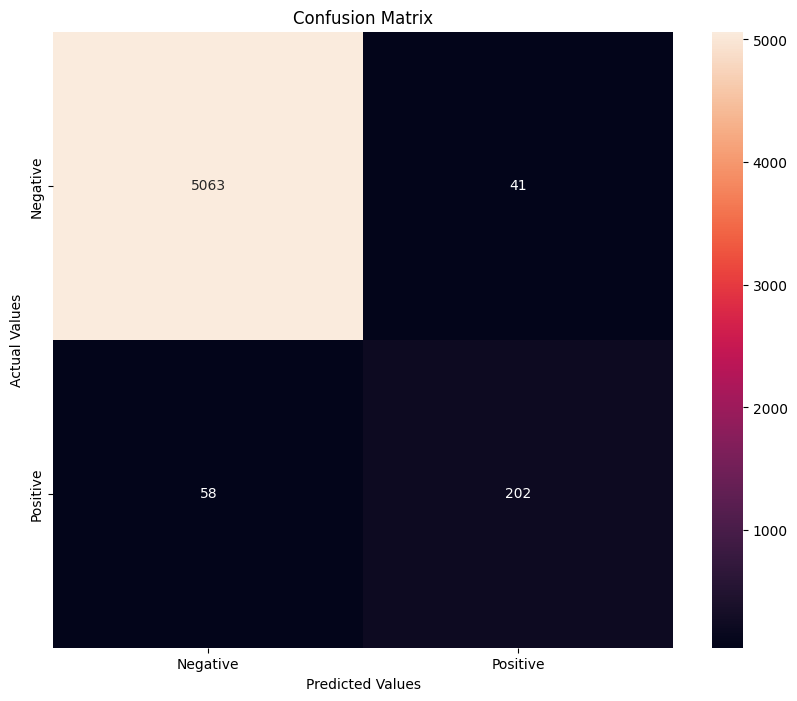

In [117]:
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- Worse F1, but more balanced confusion matrix than the model made without randomized search.

#### Usage of SMOTE

In [118]:
from imblearn.over_sampling import SMOTE

In [119]:
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.3, random_state=42)

In [120]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [121]:
rfSMOTE = RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=False, max_depth=49, 
                                max_features='sqrt', min_samples_leaf=1, min_samples_split=17, 
                                n_estimators=238, class_weight={0: 0.3, 1: 1.8})
rfSMOTE.fit(X_train_smote, y_train_smote)

RandomForestClassifier(bootstrap=False, class_weight={0: 0.3, 1: 1.8},
                       max_depth=49, min_samples_split=17, n_estimators=238,
                       n_jobs=-1, random_state=42)

In [122]:
y_pred = rfSMOTE.predict(X_test)

smoteRFResults = saveTestResults(rfSMOTE, y_pred, y_test, resultsDict1, "RandomForest SMOTE", isTrain=False)
smoteRFResults

,Precision,Recall,F1 Score,Accuracy
0,0.458427,0.784615,0.578723,0.944631


Let's try without hyperparameter tuning.

In [123]:
rfSMOTE2 = RandomForestClassifier(random_state=42, n_jobs=-1)
rfSMOTE2.fit(X_train_smote, y_train_smote)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [124]:
y_pred = rfSMOTE2.predict(X_test)

smoteRFResults2 = saveTestResults(rfSMOTE2, y_pred, y_test, resultsDict1, "RandomForest SMOTE w/o tune", isTrain=False)
smoteRFResults2

,Precision,Recall,F1 Score,Accuracy
0,0.77027,0.657692,0.709544,0.9739


Now let's tune the prediction threshold and see if that makes a difference.

In [125]:
bestThresh = getBestThreshold(rfSMOTE2, X_test, y_test, resultsDict1, "RandomForest Con")
bestThresh

{'Precision': (1.0, 0.99),
 'Recall': (0.7961538461538461, 0.3),
 'F1 Score': (0.7099391480730223, 0.47),
 'Accuracy': (0.9752050708426547, 0.61)}

In [126]:
baseProb = rfSMOTE2.predict_proba(X_test)[:, 1]
threshold = 0.47
customPred = (baseProb >= threshold).astype(int)

smoteRFThresh = saveTestResults(rfSMOTE2, customPred, y_test, resultsDict1, "RandomForest SMOTE w/o tune, thresh", isTrain=False)
smoteRFThresh

,Precision,Recall,F1 Score,Accuracy
0,0.751073,0.673077,0.709939,0.973341


- Surprisingly, there is only a very minimal difference.

### **Thoughts**

- The model performed outstanding when including content in the data for the model, when compared to its performance without the content.
- The model's performance without content, despite being much lower than its performance with the content, was actually surprisingly good, especially when it comes to accuracy.
- There is likely some further refinement that could be done to the data for it to perform even better with the random forest model, despite the already strong performance.
- If the model was refined for accuracy, with the current iteration of the data, I am confident I could get the accuracy up to 99.9%.

### **Support Vector Machines w/o Content**

In [133]:
def get_weightsSVM(model):
    '''Scores various combinations of class weights and outputs the results, 
    along with the strongest pair'''
    custom_weights = {0: 0.1, 1: 2}
    
    best_weights = {0: 0.1, 1: 2}
    best_score = 0
    
    results = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Accuracy': []
    }
    for i in range(20):
        model.set_params(class_weight=custom_weights)
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if len(results['F1 Score']) >= 2:
            try:
                if results['F1 Score'][-2] > results['F1 Score'][-1]:
                    best_weights[0] = float(results['Model'][-2].split(':')[0])
                    best_weights[1] = float(results['Model'][-2].split(':')[1])
                    best_score = results['F1 Score'][-2]
                    break
            except IndexError as e:
                print(e)
        
        custom_weights[0] = round(custom_weights[0] + 0.1, 1)
        custom_weights[1] = round(custom_weights[1] - 0.1, 1)

    while True:
        custom_weights[0] = round(custom_weights[0] + 0.1, 1)
        model.set_params(class_weight=custom_weights)
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if best_score > results['F1 Score'][-1]:
            custom_weights[0] = best_weights[0]
            break
        elif best_score < results['F1 Score'][-1]:
            best_score = results['F1 Score'][-1]
            best_weights[0] = custom_weights[0]

    while True:
        custom_weights[0] = round(custom_weights[0] - 0.1, 1)
        model.set_params(class_weight=custom_weights)
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if best_score > results['F1 Score'][-1]:
            custom_weights[0] = best_weights[0]
            break
        elif best_score < results['F1 Score'][-1]:
            best_score = results['F1 Score'][-1]
            best_weights[0] = custom_weights[0]

    while True:
        custom_weights[1] = round(custom_weights[1] + 0.1, 1)
        model.set_params(class_weight=custom_weights)
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if best_score > results['F1 Score'][-1]:
            custom_weights[1] = best_weights[1]
            break
        elif best_score < results['F1 Score'][-1]:
            best_score = results['F1 Score'][-1]
            best_weights[1] = custom_weights[1]

    while True:
        custom_weights[1] = round(custom_weights[1] - 0.1, 1)
        model.set_params(class_weight=custom_weights)
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if best_score > results['F1 Score'][-1]:
            custom_weights[1] = best_weights[1]
            break
        elif best_score < results['F1 Score'][-1]:
            best_score = results['F1 Score'][-1]
            best_weights[1] = custom_weights[1]
    
    return results

In [134]:
def scaledGamma(kernel, target, data):
    '''Function to compute relative optimal gamma value for SVM'''
    
    gammaVar = 0.0001
    decimals = 4
    
    results = {
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Accuracy': []
    }
    
    while True:
        if kernel == "poly":
            svm_classifier = SVC(kernel=kernel, gamma=gammaVar, random_state=42, degree=3)
        else:
            svm_classifier = SVC(kernel=kernel, gamma=gammaVar, random_state=42)

        svm_classifier.fit(X_train_scaled, y_train)
        this_pred = svm_classifier.predict(X_test_scaled)
        
        res = saveTestResults(svm_classifier, this_pred, target, data, "SVC", isTrain=True)
        results['Precision'].append((res['Precision'][0], gammaVar))
        results['Recall'].append((res['Recall'][0], gammaVar))
        results['F1 Score'].append((res['F1 Score'][0], gammaVar))
        results['Accuracy'].append((res['Accuracy'][0], gammaVar))

        if gammaVar >= 1:
            break
        else:
            if decimals > 2:
                decimals = decimals - 1
            gammaVar = round(gammaVar * 10, decimals)
            continue

    for key, value in results.items():
        results[key] = max(value)
    
    return results

In [135]:
def getBestGamma(target, kernel, lowerBound, upperBound):
    '''Function to compute relative optimal gamma value for SVM'''
    
    gammaVar = lowerBound
    
    results = {
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Accuracy': []
    }
    
    while True:
        svm_classifier = SVC(kernel=kernel, gamma=gammaVar, random_state=42)

        svm_classifier.fit(X_train_scaled, y_train)
        this_pred = svm_classifier.predict(X_test_scaled)
        
        res = saveTestResults(svm_classifier, this_pred, target, resultsDict1, "SVC", isTrain=True)
        results['Precision'].append((res['Precision'][0], gammaVar))
        results['Recall'].append((res['Recall'][0], gammaVar))
        results['F1 Score'].append((res['F1 Score'][0], gammaVar))
        results['Accuracy'].append((res['Accuracy'][0], gammaVar))

        if gammaVar >= upperBound:
            break
        else:
            gammaVar = round(gammaVar + 0.1, 2)
            continue

    for key, value in results.items():
        results[key] = max(value)
    
    return results

In [136]:
def scaleReg(model, target, lowerBound, upperBound):
    '''Function to compute relative optimal C value for SVM'''
    
    cVar = lowerBound
    decimals = 4
    
    results = {
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Accuracy': []
    }
    
    while True:
        model.set_params(C=cVar)

        model.fit(X_train_scaled, y_train)
        this_pred = model.predict(X_test_scaled)
        
        res = saveTestResults(model, this_pred, target, resultsDict1, "SVC", isTrain=True)
        results['Precision'].append((res['Precision'][0], cVar))
        results['Recall'].append((res['Recall'][0], cVar))
        results['F1 Score'].append((res['F1 Score'][0], cVar))
        results['Accuracy'].append((res['Accuracy'][0], cVar))

        if cVar >= upperBound:
            break
        else:
            if decimals > 2:
                decimals = decimals - 1
            cVar = round(cVar * 10, decimals)
            continue

    for key, value in results.items():
        results[key] = max(value)
    
    return results

In [137]:
def getBestReg(model, target, lowerBound, upperBound):
    '''Function to compute relative optimal C value for SVM'''
    
    cVar = lowerBound
    
    results = {
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Accuracy': []
    }
    
    while True:
        model.set_params(C=cVar)

        model.fit(X_train_scaled, y_train)
        this_pred = model.predict(X_test_scaled)
        
        res = saveTestResults(model, this_pred, target, resultsDict1, "SVC", isTrain=True)
        results['Precision'].append((res['Precision'][0], cVar))
        results['Recall'].append((res['Recall'][0], cVar))
        results['F1 Score'].append((res['F1 Score'][0], cVar))
        results['Accuracy'].append((res['Accuracy'][0], cVar))

        if cVar >= upperBound:
            break
        else:
            cVar = round(cVar + lowerBound, 4)
            continue

    for key, value in results.items():
        results[key] = max(value)
    
    return results

In [126]:
X = df5.drop(['fraudulent', 'location', 'company_profile', 'description', 'requirements', 'industry', 'function'], axis=1)
X = X.astype(bool)
y = df5['fraudulent']
y = y.astype(bool)

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [128]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()
# SVM needs scaled data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [129]:
svmVanilla = SVC(random_state=42)
svmVanilla.fit(X_train_scaled, y_train)

y_pred = svmVanilla.predict(X_test_scaled)

In [130]:
svmVanillaResults = saveTestResults(svmVanilla, y_pred, y_test, resultsDict1, "SVM NoCon Vanilla", isTrain=False)
svmVanillaResults

,Precision,Recall,F1 Score,Accuracy
0,0.818182,0.069231,0.12766,0.954139


- Off the bat, not that much worse than the vanilla, no-content results from random forest.

### Refinement

#### Gamma

In [131]:
bestGammaNoC = scaledGamma('rbf', y_test, resultsDict1)
bestGammaNoC

{'Precision': (0.8181818181818182, 0.1),
 'Recall': (0.07692307692307693, 1.0),
 'F1 Score': (0.13793103448275862, 1.0),
 'Accuracy': (0.9541387024608501, 0.1)}

- Clearly, based on this, the best gamma is 1.0

In [132]:
svmGamma = SVC(gamma=1, random_state=42)
svmGamma.fit(X_train_scaled, y_train)

y_pred = svmGamma.predict(X_test_scaled)

gammaResults = saveTestResults(svmGamma, y_pred, y_test, resultsDict1, "SVM NoCon Gam", isTrain=False)
gammaResults

,Precision,Recall,F1 Score,Accuracy
0,0.666667,0.076923,0.137931,0.953393


#### Kernel

Since results for each kernel are vastly different, and each prefers different ranges of gamma values, we actually need to find the optimal gammas for each respective kernel.

In [133]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
warnings.filterwarnings('ignore')
kernResults = {
    "Kernel": [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Accuracy': []
}
# For each kernel, add the highest recorded score for each metric
# along with its coinciding gamma value
for kernel in kernels:
    this_output = scaledGamma(kernel, y_test, resultsDict1)
    kernResults['Kernel'].append(kernel)
    kernResults['Precision'].append(this_output['Precision'])
    kernResults['Recall'].append(this_output['Recall'])
    kernResults['F1 Score'].append(this_output['F1 Score'])
    kernResults['Accuracy'].append(this_output['Accuracy'])
    
warnings.filterwarnings('default')

In [134]:
kernResultsDF = pd.DataFrame(kernResults)
kernResultsDF

,Kernel,Precision,Recall,F1 Score,Accuracy
0,linear,"(0.0, 1.0)","(0.0, 1.0)","(0.0, 1.0)","(0.9515287099179717, 1.0)"
1,rbf,"(0.8181818181818182, 0.1)","(0.07692307692307693, 1.0)","(0.13793103448275862, 1.0)","(0.9541387024608501, 0.1)"
2,poly,"(0.5319148936170213, 1.0)","(0.09615384615384616, 1.0)","(0.16286644951140064, 1.0)","(0.9520879940343028, 1.0)"
3,sigmoid,"(0.05434782608695652, 1.0)","(0.019230769230769232, 1.0)","(0.028409090909090908, 1.0)","(0.9515287099179717, 0.01)"


- 1.0 was the best gamma for rbf (the only kernel that uses gamma)
- Poly netted the best f1 score out of every kernel, albeit with a much lower precision score than rbf.

Normally, we would have to further refine the gamma. However, since the optimal value is 1, which is the highest value for the parameter, we can move on.

In [135]:
svmKernel = SVC(kernel='poly', gamma=1, random_state=42)
svmKernel.fit(X_train_scaled, y_train)

y_pred = svmKernel.predict(X_test_scaled)

kernelResults = saveTestResults(svmKernel, y_pred, y_test, resultsDict1, "SVM NoCon Kern", isTrain=False)
kernelResults

,Precision,Recall,F1 Score,Accuracy
0,0.531915,0.096154,0.162866,0.952088


#### Regularization

In [136]:
svmRegular = SVC(kernel='poly', gamma=1, random_state=42)

In [137]:
bestReg = scaleReg(svmRegular, y_test, 0.0001, 1000)
bestReg

{'Precision': (0.5681818181818182, 0.0001),
 'Recall': (0.09615384615384616, 1000.0),
 'F1 Score': (0.16447368421052633, 0.0001),
 'Accuracy': (0.9526472781506339, 0.0001)}

In [138]:
bestReg2 = getBestReg(svmRegular, y_test, 0.0001, 0.001)
bestReg2

{'Precision': (0.5681818181818182, 0.0007),
 'Recall': (0.09615384615384616, 0.001),
 'F1 Score': (0.16447368421052633, 0.0007),
 'Accuracy': (0.9526472781506339, 0.0007)}

- The difference in the results is so small, that it gets rounded off, making the values look the same.

In [139]:
svmRegular.set_params(C=0.0007)
svmRegular.fit(X_train_scaled, y_train)

y_pred = svmRegular.predict(X_test_scaled)

regResults = saveTestResults(svmRegular, y_pred, y_test, resultsDict1, "SVM NoCon Gam", isTrain=False)
regResults

,Precision,Recall,F1 Score,Accuracy
0,0.568182,0.096154,0.164474,0.952647


#### Class Weights

**Balanced**

In [140]:
svmWeight = SVC(kernel='poly', gamma=1, C=0.0007, random_state=42, class_weight='balanced')

svmWeight.fit(X_train_scaled, y_train)
y_pred = svmWeight.predict(X_test_scaled)

weightResults1 = saveTestResults(svmWeight, y_pred, y_test, resultsDict1, "SVM NoCon W", isTrain=True)
weightResults1

,Precision,Recall,F1 Score,Accuracy
0,0.139956,0.742308,0.235509,0.766406


- When it comes to F1, 'balanced' actually leads to an improvement. But let's try custom weights and see if that makes it even better.

**Custom**

In [141]:
svmCustomWeights1 = get_weightsSVM(svmWeight)

In [142]:
svmCustomWeights1DF = pd.DataFrame(svmCustomWeights1)
svmCustomWeights1DF

,Model,Precision,Recall,F1 Score,Accuracy
0,0.1:2,0.185466,0.657692,0.289340,0.843400
1,0.2:1.9,0.188326,0.657692,0.292808,0.846010
2,0.3:1.8,0.287154,0.438462,0.347032,0.920022
3,0.4:1.7,0.297753,0.407692,0.344156,0.924683
4,0.5:1.7,0.298551,0.396154,0.340496,0.925615
5,0.2:1.7,0.193878,0.657692,0.299475,0.850858
6,0.3:1.8,0.287154,0.438462,0.347032,0.920022
7,0.3:1.9,0.247036,0.480769,0.326371,0.903803
8,0.3:1.7,0.291139,0.442308,0.351145,0.920768
9,0.3:1.6,0.291990,0.434615,0.349304,0.921514


- 0.3 : 1.7 seems optimal for F1.

In [143]:
svmWeight.set_params(class_weight={0: 0.3, 1: 1.7})
svmWeight.fit(X_train_scaled, y_train)
y_pred = svmWeight.predict(X_test_scaled)

weightResults2 = saveTestResults(svmWeight, y_pred, y_test, resultsDict1, "SVM NoCon W", isTrain=False)
weightResults2

,Precision,Recall,F1 Score,Accuracy
0,0.291139,0.442308,0.351145,0.920768


### **Support Vector Machines w/ Content**

In [138]:
bow_vector = CountVectorizer(max_features=3000)
feature = bow_vector.fit_transform(df6['content'])
feature = feature.toarray()

In [139]:
label = df6['fraudulent']

In [140]:
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.3, random_state=42)

In [142]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()

In [143]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [144]:
svmVanillaCon = SVC(random_state=42)
svmVanillaCon = svmVanillaCon.fit(X_train_scaled, y_train)

In [145]:
y_pred = svmVanillaCon.predict(X_test_scaled)

svmConResults = saveTestResults(svmVanillaCon, y_pred, y_test, resultsDict1, "SVM Vanilla Con", isTrain=False)
svmConResults

,Precision,Recall,F1 Score,Accuracy
0,1.0,0.530769,0.693467,0.977256


In [ ]:
bestGammaCon = scaledGamma('rbf', y_test, resultsDict1)
bestGammaCon

At this point, I made the decision that the SVM model wasn't worth the trouble, as it takes even longer to run than random forest, and shows worse potential, when it comes to F1 scores.

### **XGBoost**

In [127]:
def getBestDepth(model, X_train, y_train):
    '''Function to compute optimal max_depth for XGBoost'''
    
    depth = 1
    
    results = {
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Accuracy': []
    }
    
    while True:
        model.set_params(max_depth=depth)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        res = saveTestResults(model, y_pred, y_test, resultsDict1, "XGBoost", isTrain=True)
        results['Precision'].append((res['Precision'][0], depth))
        results['Recall'].append((res['Recall'][0], depth))
        results['F1 Score'].append((res['F1 Score'][0], depth))
        results['Accuracy'].append((res['Accuracy'][0], depth))

        if depth >= 10:
            break
        else:
            depth = round(depth + 1, 2)
            continue

    for key, value in results.items():
        results[key] = max(value)
    
    return results

In [128]:
def getBestLearn(model, X_train, y_train, lowerBound, upperBound):
    '''Function to compute optimal max_depth for XGBoost'''
    
    learn = lowerBound
    
    results = {
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Accuracy': []
    }
    
    while True:
        model.set_params(learning_rate=learn)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        res = saveTestResults(model, y_pred, y_test, resultsDict1, "XGBoost", isTrain=True)
        results['Precision'].append((res['Precision'][0], learn))
        results['Recall'].append((res['Recall'][0], learn))
        results['F1 Score'].append((res['F1 Score'][0], learn))
        results['Accuracy'].append((res['Accuracy'][0], learn))

        if learn >= upperBound:
            break
        else:
            learn = round(learn + 0.01, 3)
            continue

    for key, value in results.items():
        results[key] = max(value)

    print("hi")
    return results

In [129]:
def get_weights(model):
    '''Scores various combinations of class weights and outputs the results, 
    along with the strongest pair'''
    custom_weights = {0: 0.1, 1: 2}

    best_weights = {0: 0.1, 1: 2}
    best_score = 0
    
    results = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Accuracy': []
    }
    for i in range(20):
        model.set_params(class_weight=custom_weights)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if len(results['F1 Score']) >= 2:
            try:
                if results['F1 Score'][-2] > results['F1 Score'][-1]:
                    best_weights[0] = float(results['Model'][-2].split(':')[0])
                    best_weights[1] = float(results['Model'][-2].split(':')[1])
                    best_score = results['F1 Score'][-2]
                    break
            except IndexError as e:
                print(e)
        
        custom_weights[0] = round(custom_weights[0] + 0.1, 1)
        custom_weights[1] = round(custom_weights[1] - 0.1, 1)

    while True:
        custom_weights[0] = round(custom_weights[0] + 0.1, 1)
        model.set_params(class_weight=custom_weights)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if best_score > results['F1 Score'][-1]:
            custom_weights[0] = best_weights[0]
            break
        elif best_score < results['F1 Score'][-1]:
            best_score = results['F1 Score'][-1]
            best_weights[0] = custom_weights[0]

    while True:
        custom_weights[0] = round(custom_weights[0] - 0.1, 1)
        model.set_params(class_weight=custom_weights)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if best_score > results['F1 Score'][-1]:
            custom_weights[0] = best_weights[0]
            break
        elif best_score < results['F1 Score'][-1]:
            best_score = results['F1 Score'][-1]
            best_weights[0] = custom_weights[0]

    while True:
        custom_weights[1] = round(custom_weights[1] + 0.1, 1)
        model.set_params(class_weight=custom_weights)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if best_score > results['F1 Score'][-1]:
            custom_weights[1] = best_weights[1]
            break
        elif best_score < results['F1 Score'][-1]:
            best_score = results['F1 Score'][-1]
            best_weights[1] = custom_weights[1]

    while True:
        custom_weights[1] = round(custom_weights[1] - 0.1, 1)
        model.set_params(class_weight=custom_weights)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        res = saveTestResults(model, pred, y_test, results, f"{custom_weights[0]}:{custom_weights[1]}", isTrain=False)

        if best_score > results['F1 Score'][-1]:
            custom_weights[1] = best_weights[1]
            break
        elif best_score < results['F1 Score'][-1]:
            best_score = results['F1 Score'][-1]
            best_weights[1] = custom_weights[1]
    
    return results

In [130]:
from xgboost import XGBClassifier

In [131]:
df6 = df5.copy()
df6.drop(['function', 'industry', 'location'], axis=1, inplace=True)

In [132]:
for col in ['company_profile', 'description', 'requirements']:
    df6[col] = df6[col].astype(pd.StringDtype())

In [133]:
# Combine the lists from three columns into one column
df6['content'] = df6.apply(lambda row: row['company_profile'] + row['description'] + row['requirements'], axis=1)
df6.drop(['company_profile', 'description', 'requirements'], axis=1, inplace=True)

In [134]:
bow_vector = CountVectorizer(max_features=3000)
feature = bow_vector.fit_transform(df6['content'])
feature = feature.toarray()

In [135]:
df6['fraudulent'] = df6['fraudulent'].astype(bool)
label = df6['fraudulent']

In [136]:
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.3, random_state=42)

In [137]:
xgBoost = XGBClassifier(random_state=42)
xgBoost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [138]:
y_pred_train = xgBoost.predict(X_train)

In [139]:
xgbTrainResults = saveTestResults(xgBoost, y_pred_train, y_train, resultsDict1, "XGBoost", isTrain=True)
xgbTrainResults

,Precision,Recall,F1 Score,Accuracy
0,1.0,0.966942,0.983193,0.998402


In [140]:
y_pred = xgBoost.predict(X_test)

xgbResults = saveTestResults(xgBoost, y_pred, y_test, resultsDict1, "XGBoost", isTrain=False)
xgbResults

,Precision,Recall,F1 Score,Accuracy
0,0.943005,0.7,0.803532,0.983408


### Refinement

#### Max Depth

In [141]:
xgBoost2 = XGBClassifier(random_state=42)
bestDepth = getBestDepth(xgBoost2, X_train, y_train)

In [142]:
bestDepth

{'Precision': (0.9629629629629629, 7),
 'Recall': (0.7115384615384616, 8),
 'F1 Score': (0.8167770419426048, 8),
 'Accuracy': (0.9845264727815063, 8)}

In [143]:
xgBoost2.set_params(max_depth=8, random_state=42)
xgBoost2.fit(X_train, y_train)
y_pred = xgBoost2.predict(X_test)

xgbResults2 = saveTestResults(xgBoost2, y_pred, y_test, resultsDict1, "XGBoost Depth", isTrain=False)
xgbResults2

,Precision,Recall,F1 Score,Accuracy
0,0.958549,0.711538,0.816777,0.984526


In [144]:
matrix = confusion_matrix(y_test, y_pred)
matrix = pd.DataFrame(matrix, index=['Negative', 'Positive'],
                              columns=['Negative', 'Positive'])
print(matrix)

          Negative  Positive
Negative      5096         8
Positive        75       185


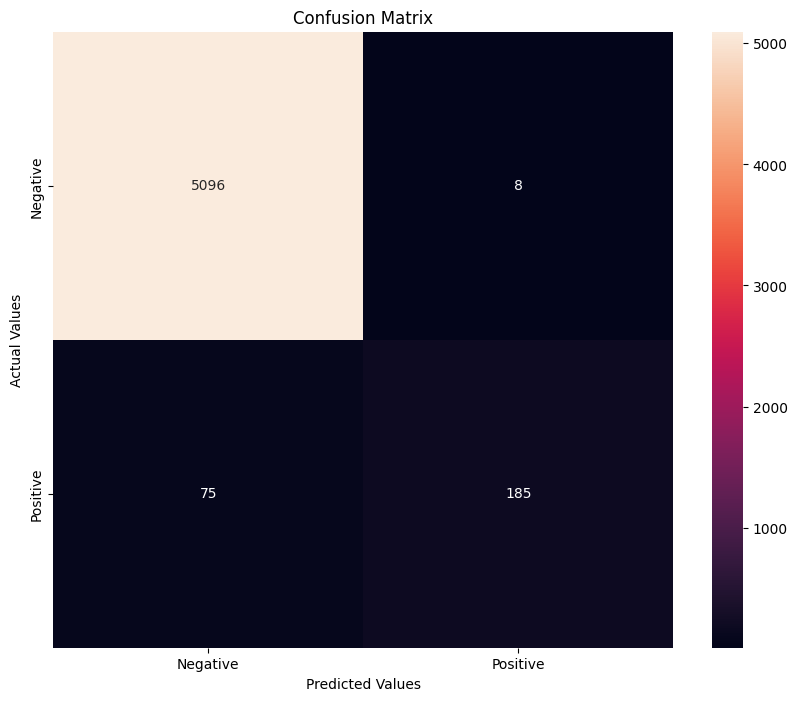

In [145]:
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#### Usage of SMOTE

In [146]:
#!pip install imblearn

In [147]:
from imblearn.over_sampling import SMOTE

In [148]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [149]:
xgBoost3 = XGBClassifier(random_state=42, max_depth=8)
xgBoost3.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [150]:
y_pred_train = xgBoost3.predict(X_train)

xgBoostTrain2 = saveTestResults(xgBoost3, y_pred_train, y_train, resultsDict1, "XGBoost SMOTE", isTrain=True)
xgBoostTrain2

,Precision,Recall,F1 Score,Accuracy
0,0.948195,0.998347,0.972625,0.997283


In [151]:
y_pred = xgBoost3.predict(X_test)

xgBoostSmote = saveTestResults(xgBoost3, y_pred, y_test, resultsDict1, "XGBoost SMOTE", isTrain=False)
xgBoostSmote

,Precision,Recall,F1 Score,Accuracy
0,0.738462,0.738462,0.738462,0.974646


In [152]:
matrix = confusion_matrix(y_test, y_pred)
matrix = pd.DataFrame(matrix, index=['Negative', 'Positive'],
                              columns=['Negative', 'Positive'])
print(matrix)

          Negative  Positive
Negative      5036        68
Positive        68       192


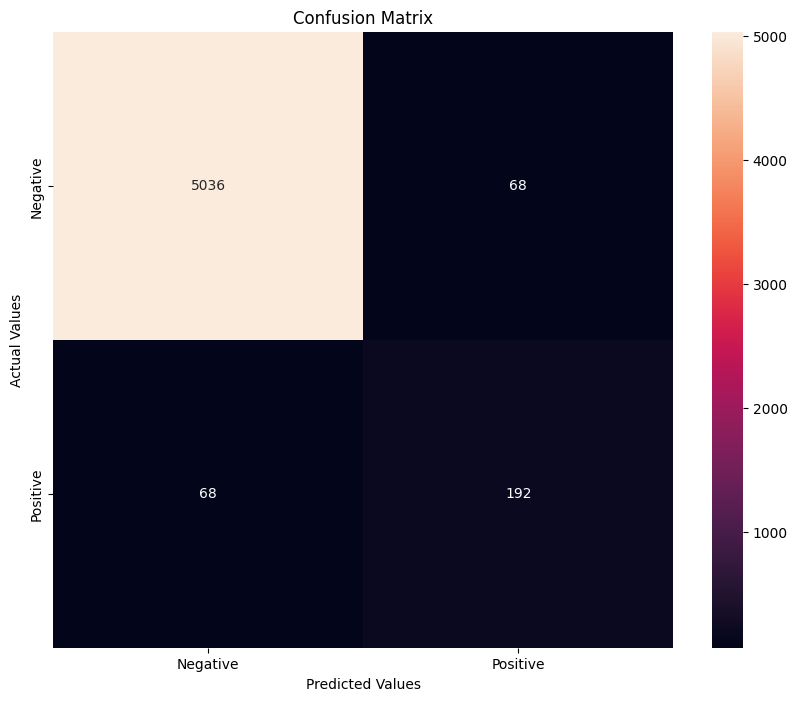

In [153]:
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Test results when using SMOTE are significantly worse, but it is possible that, when using the SMOTE data, the model prefers a different max_depth, so we will check.

In [154]:
bestDepth2 = getBestDepth(xgBoost3, X_train_smote, y_train_smote)
bestDepth2

{'Precision': (0.7519685039370079, 10),
 'Recall': (0.7923076923076923, 3),
 'F1 Score': (0.7431906614785992, 10),
 'Accuracy': (0.9753914988814317, 10)}

Unfortunately, values 1-10 didn't make much of a difference, so we'll proceed without SMOTE.

#### Learning Rate

In [155]:
xgBoost4 = XGBClassifier(random_state=42, max_depth=8)

bestLearn = getBestLearn(xgBoost4, X_train, y_train, 0.1, 1)
bestLearn

KeyboardInterrupt: 

- The F1 score improves considerably when using a learning_rate value of 0.85, so that is what will be used going forward.

In [156]:
xgBoost4 = XGBClassifier(random_state=42, max_depth=8, learning_rate=0.85)
xgBoost4.fit(X_train, y_train)

y_pred = xgBoost4.predict(X_test)

xgBoostLearn = saveTestResults(xgBoost4, y_pred, y_test, resultsDict1, "XGBoost LearnRate", isTrain=False)
xgBoostLearn

,Precision,Recall,F1 Score,Accuracy
0,0.95098,0.746154,0.836207,0.985831


Out of curiousity, I want to see if changing learning rate will salvage the results, when using SMOTE.

In [155]:
xgBoost5 = XGBClassifier(random_state=42, max_depth=8)

testLearn = getBestLearn(xgBoost5, X_train_smote, y_train_smote, 0.1, 1)
testLearn

{'Precision': (0.7831325301204819, 0.61),
 'Recall': (0.7653846153846153, 0.33),
 'F1 Score': (0.7662082514734774, 0.61),
 'Accuracy': (0.9778150633855331, 0.61)}

Let's try again with a max_depth value of 10, which is what was preferred for the SMOTE data.

In [157]:
xgBoost5 = XGBClassifier(random_state=42, max_depth=10)

testLearn3 = getBestLearn(xgBoost5, X_train_smote, y_train_smote, 0.1, 1)
testLearn3

{'Precision': (0.7842323651452282, 0.88),
 'Recall': (0.7615384615384615, 0.78),
 'F1 Score': (0.7635658914728682, 0.68),
 'Accuracy': (0.9774422073079791, 0.82)}

Even with this optimization, the results are hardly comparable to those that were done without the use of SMOTE, so we'll move on without it, to save time.

#### Booster

**Linear**

In [170]:
xgbLinear = XGBClassifier(random_state=42, max_depth=8, booster='gblinear', learning_rate=0.68)
xgbLinear.fit(X_train, y_train)
y_pred = xgbLinear.predict(X_test)

In [171]:
xgbLinearRes = saveTestResults(xgbLinear, y_pred, y_test, resultsDict1, "XGBoost Linear", isTrain=False)
xgbLinearRes

,Precision,Recall,F1 Score,Accuracy
0,0.677419,0.726923,0.701299,0.969985


- The linear booster is most likely undersampled for this dataset, which would make sense, given the small number of positives. The only way to fix this would be to oversample, which I will save for another iteration.

### **Thoughts**

While the results of the XGBoost model are promising, especially considering the small amount of tuning that was done, I want to move on to trying different iterations of the dataset, to see if it leads to a larger jump towards my goal of reaching an F1 of 0.9, without using deep learning.

## **Model Building - Iteration 2**

### New DataFrame

Before we can actually do any model building, we actually need to instantiate a new version of the dataset, which will be used for this iteration.

In [157]:
df5.head()

,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,industry,function,fraudulent,...,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_experience_Unknown
0,US,"[food, created, groundbreaking, awardwinning, ...","[food, fastgrowing, james, beard, awardwinning...","[experience, content, management, system, majo...",0,1,0,Unknown,Marketing,0,...,False,False,False,False,False,False,True,False,False,False
1,NZ,"[second, world, cloud, video, production, serv...","[organised, focused, vibrant, awesome, passion...","[expect, key, responsibility, communicate, cli...",0,1,0,Marketing and Advertising,Customer Service,0,...,False,False,False,False,False,False,False,False,True,False
2,US,"[valor, service, provides, workforce, solution...","[client, located, houston, actively, seeking, ...","[implement, precommissioning, commissioning, p...",0,1,0,Unknown,Unknown,0,...,False,False,True,False,False,False,False,False,False,True
3,US,"[passion, improving, quality, life, geography,...","[company, esri, environmental, system, researc...","[education, bachelor, master, gi, business, ad...",0,1,0,Computer Software,Sales,0,...,False,False,False,False,False,False,False,True,False,False
4,US,"[spotsource, solution, llc, global, human, cap...","[job, title, itemization, review, managerlocat...","[qualification, right, license, state, texasdi...",0,1,1,Hospital & Health Care,Health Care Provider,0,...,False,False,False,False,False,False,False,True,False,False


If we recall to the EDA, the three columns "has_questions", "telecommuting", and "required_experience" were not highly indicative of the fraudulent results. Despite this, I left them in, because there did appear to be a small amount of correlation. For this iteration, we will be removing them.

In [158]:
df7 = df4.copy()

In [159]:
df7 = df7.drop(['required_experience', 'telecommuting', 'has_questions', 
                'location', 'industry', 'function', 'title'], axis=1)

In [160]:
df7.head()

,company_profile,description,requirements,has_company_logo,employment_type,fraudulent
0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,1,Other,0
1,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,1,Full-time,0
2,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,1,Unknown,0
3,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",1,Full-time,0
4,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,1,Full-time,0


We also need to encode, and process all of the text.

In [161]:
df7 = pd.get_dummies(df7, columns=['employment_type'], drop_first=True)

In [162]:
df7['content'] = df7['company_profile'] + ' ' + df7['description'] + ' ' + df7['requirements']
df7 = df7.drop(['company_profile', 'description', 'requirements'], axis=1)

In [163]:
df7.head()

,has_company_logo,fraudulent,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,content
0,1,0,False,True,False,False,False,"We're Food52, and we've created a groundbreaki..."
1,1,0,True,False,False,False,False,"90 Seconds, the worlds Cloud Video Production ..."
2,1,0,False,False,False,False,True,Valor Services provides Workforce Solutions th...
3,1,0,True,False,False,False,False,Our passion for improving quality of life thro...
4,1,0,True,False,False,False,False,SpotSource Solutions LLC is a Global Human Cap...


In [164]:
df8 = df7.copy()

**De-contraction**

In [165]:
for col in ['content']:
    for i, row in df7.iterrows():
        content = df7.at[i, col]
        clean_content = replace_contractions(content)
        df7.at[i,col] = clean_content

**Removal of Numbers**

In [166]:
df7['content'] = df7['content'].apply(lambda x: remove_numbers(x))

**Tokenization**

In [167]:
df7['content'] = df7.apply(lambda row: nltk.word_tokenize(row['content']), axis=1)

**Removing Non-ascii**

In [168]:
df7['content'] = df7['content'].apply(lambda x: remove_non_ascii(x))

**Lowercase**

In [169]:
df7['content'] = df7['content'].apply(lambda x: to_lowercase(x))

**Removing Punctuation**

In [170]:
df7['content'] = df7['content'].apply(lambda x: remove_punctuation(x))

**Removing Stopwords**

In [171]:
df7['content'] = df7['content'].apply(lambda x: remove_stopwords(x))

**Lemmatizing**

In [172]:
df7['content'] = df7['content'].apply(lambda x: lemmatize_list(x))

### Random Forest

In [173]:
resultsDict2 = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Accuracy': []
}

In [174]:
df7['content'] = df7['content'].astype(pd.StringDtype())

In [175]:
df7.head()

,has_company_logo,fraudulent,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,content
0,1,0,False,True,False,False,False,"['food', 'created', 'groundbreaking', 'awardwi..."
1,1,0,True,False,False,False,False,"['second', 'world', 'cloud', 'video', 'product..."
2,1,0,False,False,False,False,True,"['valor', 'service', 'provides', 'workforce', ..."
3,1,0,True,False,False,False,False,"['passion', 'improving', 'quality', 'life', 'g..."
4,1,0,True,False,False,False,False,"['spotsource', 'solution', 'llc', 'global', 'h..."


In [176]:
bow_vector = CountVectorizer(max_features=3000)
feature = bow_vector.fit_transform(df7['content'])
feature = feature.toarray()

In [177]:
df7['fraudulent'] = df7['fraudulent'].astype(bool)
label = df7['fraudulent']

In [178]:
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.3, random_state=42)

In [179]:
rf2 = RandomForestClassifier(random_state=42, n_jobs=-1)
rf2 = rf2.fit(X_train, y_train)

In [180]:
y_pred = rf2.predict(X_test)

rf2Results = saveTestResults(rf2, y_pred, y_test, resultsDict2, "Random Forest Vanilla", isTrain=False)
rf2Results

,Precision,Recall,F1 Score,Accuracy
0,1.0,0.592308,0.743961,0.980239


In [181]:
rfContentResultsTest

,Precision,Recall,F1 Score,Accuracy
0,1.0,0.592308,0.743961,0.980239


Comparing with the first Random Forest results in the previous iteration, we can see that the scores are somehow fully identical, despite the difference in the dataframe. I suppose this goes to show how unimpactful the dropped columns truly were.

Because of this, there is no sense in continuing with this iteration.

## **Model Building - Iteration 3**

### Pipeline

We'll continue on with the last used dataframe, but rather than trying with a vanilla SMOTE sampling method, we are going to try using Pipeline, and undersample the majority.

The reason I'm doing this is that, based on the results from tuning the previous models, there is a clear bias towards the majority. It has already been shown to be possible to balance the models to the point that they are roughly equal, however, this requires such a strong bias *against* the majority, that the models are more or less capped, and cannot improve beyond ~80 F1.

In [182]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [183]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

In [184]:
pipeline = Pipeline([('smote', smote), ('undersampler', undersampler)])

In [185]:
X_train_resample, y_train_resample = pipeline.fit_resample(X_train, y_train)

##### First RF Test

In [186]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train_resample, y_train_resample)
y_pred = rf.predict(X_test)

In [187]:
rfResampleResults = saveTestResults(rf, y_pred, y_test, resultsDict2, "RandomForest Resample", isTrain=False)
rfResampleResults

,Precision,Recall,F1 Score,Accuracy
0,0.769585,0.642308,0.70021,0.973341


Not the results we were hoping for, but more balanced than the regular dataset, so we'll try to optimize threshold, and compare to the base dataset.

In [188]:
bestThresh10 = getBestThreshold(rf, X_test, y_test, resultsDict1, "RandomForest")
bestThresh10

{'Precision': (0.9883720930232558, 0.95),
 'Recall': (0.7961538461538461, 0.3),
 'F1 Score': (0.7116564417177914, 0.48),
 'Accuracy': (0.9753914988814317, 0.64)}

In [189]:
baseProb = rf.predict_proba(X_test)[:, 1]
threshold = 0.48
customPred = (baseProb >= threshold).astype(int)

In [190]:
rfResampleResults2 = saveTestResults(rf, customPred, y_test, resultsDict2, "RandomForest Resample Thresh", isTrain=False)
rfResampleResults2

,Precision,Recall,F1 Score,Accuracy
0,0.759825,0.669231,0.711656,0.973714


Slight improvement, but not what I was hoping for.

## **Model Building - Iteration 4**

I realized that my features in previous iterations only included the 'content' column, rather than all of the features I had intended, so I am now going to do it correctly, and see what kind of difference it makes.

In [191]:
# Backup
df9 = df8.copy()

In [192]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [193]:
content = pd.DataFrame(df8['content'])
label = df8['fraudulent'].astype(bool)

In [194]:
features = df8.drop(['content', 'fraudulent'], axis=1)

In [195]:
df8['has_company_logo'] = df8['has_company_logo'].astype(bool)

In [196]:
bow_vector = CountVectorizer(max_features=3000)
content = bow_vector.fit_transform(content['content'])

In [197]:
features = np.hstack((content.toarray(), features.values))

In [198]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)

#### Random Forest Test

In [199]:
rfFull = RandomForestClassifier(random_state=42, n_jobs=-1)
rfFull.fit(X_train, y_train)
y_pred = rfFull.predict(X_test)

In [200]:
rfFullResults = saveTestResults(rfFull, y_pred, y_test, resultsDict2, "RandomForest Full", isTrain=False)
rfFullResults

,Precision,Recall,F1 Score,Accuracy
0,1.0,0.565385,0.722359,0.978934


In [201]:
resultsDict1 = pd.DataFrame(resultsDict1)
resultsDict1.iloc[6]

Model        RandomForest SMOTE
Precision              0.458427
Recall                 0.784615
F1 Score               0.578723
Accuracy               0.944631
Name: 6, dtype: object

Comparing to the original results of the base random forest model, we can see that they've actually gotten worse, when including more features, other than just the text content.

Let's try resampling with SMOTE.

In [203]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [204]:
rfFull.fit(X_train_smote, y_train_smote)
y_pred = rfFull.predict(X_test)

In [205]:
rfFullSmote = saveTestResults(rfFull, y_pred, y_test, resultsDict2, "RandomForest Full SMOTE", isTrain=False)
rfFullSmote

,Precision,Recall,F1 Score,Accuracy
0,0.899441,0.619231,0.733485,0.978188


Similarly to previous uses of SMOTE, the recall score is much higher, at the expense of precision.

Let's try creating a custom prediction using SMOTE.

In [206]:
bestThreshFull = getBestThreshold(rfFull, X_test, y_test, resultsDict2, "RandomForest")
bestThreshFull

{'Precision': (1.0, 0.99),
 'Recall': (0.7807692307692308, 0.3),
 'F1 Score': (0.7788649706457925, 0.33),
 'Accuracy': (0.9798657718120806, 0.46)}

In [207]:
baseProb = rfFull.predict_proba(X_test)[:, 1]
threshold = 0.33
customPred = (baseProb >= threshold).astype(int)

In [208]:
rfFullSmoteThresh = saveTestResults(rfFull, customPred, y_test, resultsDict2, "RandomForest Full SMOTE Thresh", isTrain=False)
rfFullSmoteThresh

,Precision,Recall,F1 Score,Accuracy
0,0.792829,0.765385,0.778865,0.978934


#### Pipeline

In [209]:
import spacy
from sklearn.base import TransformerMixin

In [210]:
undersampler = RandomUnderSampler(random_state=42)
pipeline = Pipeline([('smote', smote), 
                     ('undersampler', undersampler),
                     ('classifier', rfFull)])

In [211]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [212]:
y_pred = rfFull.predict(X_test)

In [213]:
rfFullPipeline = saveTestResults(rfFull, y_pred, y_test, resultsDict2, "RandomForest Full Pipeline", isTrain=False)
rfFullPipeline

,Precision,Recall,F1 Score,Accuracy
0,0.909091,0.615385,0.733945,0.978374


**Threshold**

In [214]:
fullPipelineThresh = getBestThreshold(pipeline, X_test, y_test, resultsDict2, "RandomForest")
fullPipelineThresh

{'Precision': (1.0, 0.99),
 'Recall': (0.7769230769230769, 0.3),
 'F1 Score': (0.7707509881422925, 0.33),
 'Accuracy': (0.9793064876957495, 0.54)}

In [215]:
baseProb = pipeline.predict_proba(X_test)[:, 1]
threshold = 0.33
customPred = (baseProb >= threshold).astype(int)

In [216]:
rfFullPipelineThresh = saveTestResults(pipeline, customPred, y_test, resultsDict2, "Random Forest Full Pipeline Thresh", isTrain=False)
rfFullPipelineThresh

,Precision,Recall,F1 Score,Accuracy
0,0.792683,0.75,0.770751,0.978374


Somehow, we are making no progress whatsoever, so let's try something different.

## **Model Building - Iteration 5**

In [217]:
# Creating Backup
df10 = df9.copy()

In [218]:
df10.head()

,has_company_logo,fraudulent,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,content
0,1,0,False,True,False,False,False,"We're Food52, and we've created a groundbreaki..."
1,1,0,True,False,False,False,False,"90 Seconds, the worlds Cloud Video Production ..."
2,1,0,False,False,False,False,True,Valor Services provides Workforce Solutions th...
3,1,0,True,False,False,False,False,Our passion for improving quality of life thro...
4,1,0,True,False,False,False,False,SpotSource Solutions LLC is a Global Human Cap...


This time around, we're going to add some (hopefully) useful new columns to the dataframe, and see if that makes any sort of significant difference.

In [219]:
from nltk.tokenize import sent_tokenize, word_tokenize

##### **Avg. Words per Sentence**

In [220]:
def avgWords(text):
    sentences = sent_tokenize(text)
    words = [len(word_tokenize(sentence)) for sentence in sentences]
    if words:
        return sum(words) / len(words)
    else:
        return 0

In [221]:
df9['avg_words_per_sentence'] = df9['content'].apply(avgWords)

In [222]:
df9.head()

,has_company_logo,fraudulent,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,content,avg_words_per_sentence
0,1,0,False,True,False,False,False,"We're Food52, and we've created a groundbreaki...",62.714286
1,1,0,True,False,False,False,False,"90 Seconds, the worlds Cloud Video Production ...",38.350000
2,1,0,False,False,False,False,True,Valor Services provides Workforce Solutions th...,48.375000
3,1,0,True,False,False,False,False,Our passion for improving quality of life thro...,76.444444
4,1,0,True,False,False,False,False,SpotSource Solutions LLC is a Global Human Cap...,34.312500


##### **# of Sentences**

In [223]:
def numSentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

In [224]:
df9['sentences'] = df9['content'].apply(numSentences)

In [225]:
df9.head()

,has_company_logo,fraudulent,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,content,avg_words_per_sentence,sentences
0,1,0,False,True,False,False,False,"We're Food52, and we've created a groundbreaki...",62.714286,7
1,1,0,True,False,False,False,False,"90 Seconds, the worlds Cloud Video Production ...",38.350000,20
2,1,0,False,False,False,False,True,Valor Services provides Workforce Solutions th...,48.375000,8
3,1,0,True,False,False,False,False,Our passion for improving quality of life thro...,76.444444,9
4,1,0,True,False,False,False,False,SpotSource Solutions LLC is a Global Human Cap...,34.312500,16


##### **# of Unique Words**

In [226]:
def uniqueWords(text):
    words = word_tokenize(text)
    uniques = set(words)
    return len(uniques)

In [227]:
df9['unique_words'] = df9['content'].apply(uniqueWords)

In [228]:
df9.head()

,has_company_logo,fraudulent,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,content,avg_words_per_sentence,sentences,unique_words
0,1,0,False,True,False,False,False,"We're Food52, and we've created a groundbreaki...",62.714286,7,243
1,1,0,True,False,False,False,False,"90 Seconds, the worlds Cloud Video Production ...",38.350000,20,317
2,1,0,False,False,False,False,True,Valor Services provides Workforce Solutions th...,48.375000,8,217
3,1,0,True,False,False,False,False,Our passion for improving quality of life thro...,76.444444,9,315
4,1,0,True,False,False,False,False,SpotSource Solutions LLC is a Global Human Cap...,34.312500,16,337


##### **Avg. Word Length**

In [229]:
def wordLength(text):
    words = word_tokenize(text)
    lengths = [len(word) for word in words]
    if lengths:
        return sum(lengths) / len(lengths)
    else:
        return 0

In [230]:
df9['average_word_length'] = df9['content'].apply(wordLength)

In [231]:
df9.head()

,has_company_logo,fraudulent,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,content,avg_words_per_sentence,sentences,unique_words,average_word_length
0,1,0,False,True,False,False,False,"We're Food52, and we've created a groundbreaki...",62.714286,7,243,5.159453
1,1,0,True,False,False,False,False,"90 Seconds, the worlds Cloud Video Production ...",38.350000,20,317,5.379400
2,1,0,False,False,False,False,True,Valor Services provides Workforce Solutions th...,48.375000,8,217,5.798450
3,1,0,True,False,False,False,False,Our passion for improving quality of life thro...,76.444444,9,315,5.864826
4,1,0,True,False,False,False,False,SpotSource Solutions LLC is a Global Human Cap...,34.312500,16,337,6.116576


#### Normalization

In [232]:
from sklearn.preprocessing import MinMaxScaler

cols = ['avg_words_per_sentence', 'sentences', 'unique_words', 'average_word_length']

for col in cols:
    scaler = MinMaxScaler()
    scaler.fit(df9[[col]])
    df9[[col]] = scaler.transform(df9[[col]])

In [233]:
df9.head()

,has_company_logo,fraudulent,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_Unknown,content,avg_words_per_sentence,sentences,unique_words,average_word_length
0,1,0,False,True,False,False,False,"We're Food52, and we've created a groundbreaki...",0.114230,0.071429,0.308087,0.256502
1,1,0,True,False,False,False,False,"90 Seconds, the worlds Cloud Video Production ...",0.066829,0.226190,0.403081,0.275797
2,1,0,False,False,False,False,True,Valor Services provides Workforce Solutions th...,0.086333,0.083333,0.274711,0.312558
3,1,0,True,False,False,False,False,Our passion for improving quality of life thro...,0.140942,0.095238,0.400513,0.318381
4,1,0,True,False,False,False,False,SpotSource Solutions LLC is a Global Human Cap...,0.058974,0.178571,0.428755,0.340465


#### Separating Data

In [234]:
content = pd.DataFrame(df9['content'])
label = df9['fraudulent'].astype(bool)

In [235]:
features = df9.drop(['content', 'fraudulent'], axis=1)
df9['has_company_logo'] = df9['has_company_logo'].astype(bool)

In [236]:
bow_vector = CountVectorizer(max_features=3000)
content = bow_vector.fit_transform(content['content'])

In [237]:
features = np.hstack((content.toarray(), features.values))

In [238]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)

### Random Forest

In [239]:
rfMoreFeatures = RandomForestClassifier(random_state=42, n_jobs=-1)
rfMoreFeatures.fit(X_train, y_train)
y_pred = rfMoreFeatures.predict(X_test)

In [240]:
rfMoreFeaturesRes = saveTestResults(rfMoreFeatures, y_pred, y_test, resultsDict2, "RandomForest +Features", isTrain=False)
rfMoreFeaturesRes

,Precision,Recall,F1 Score,Accuracy
0,1.0,0.557692,0.716049,0.978561


Okay, somehow it's now getting worse, despite adding better features. So let's try without the content, and see if the new features will compensate.

In [241]:
label = df9['fraudulent'].astype(bool)
features = df9.drop(['content', 'fraudulent'], axis=1)
df9['has_company_logo'] = df9['has_company_logo'].astype(bool)

In [242]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)

In [243]:
rfOther = RandomForestClassifier(random_state=42, n_jobs=-1)
rfOther.fit(X_train, y_train)
y_pred = rfOther.predict(X_test)

In [244]:
rfOtherResults = saveTestResults(rfOther, y_pred, y_test, resultsDict2, "RandomForest +OtherFeats", isTrain=False)
rfOtherResults

,Precision,Recall,F1 Score,Accuracy
0,0.886792,0.361538,0.513661,0.966816


Let's try with the new features and content, but nothing else.

In [245]:
label = df9['fraudulent'].astype(bool)
content = pd.DataFrame(df9['content'])
features = df9.drop(['content', 'fraudulent', 'employment_type_Full-time', 'employment_type_Other',
                     'employment_type_Part-time', 'employment_type_Temporary', 'employment_type_Unknown'], axis=1)

In [246]:
features

,has_company_logo,avg_words_per_sentence,sentences,unique_words,average_word_length
0,True,0.114230,0.071429,0.308087,0.256502
1,True,0.066829,0.226190,0.403081,0.275797
2,True,0.086333,0.083333,0.274711,0.312558
3,True,0.140942,0.095238,0.400513,0.318381
4,True,0.058974,0.178571,0.428755,0.340465
...,...,...,...,...,...
17875,True,0.068580,0.226190,0.477535,0.220611
17876,True,0.054660,0.238095,0.495507,0.273231
17877,False,0.068677,0.107143,0.286264,0.337605
17878,False,0.016732,0.166667,0.156611,0.200276


In [247]:
bow_vector = CountVectorizer(max_features=3000)
content = bow_vector.fit_transform(content['content'])

In [248]:
features = np.hstack((content.toarray(), features.values))

In [249]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)

In [250]:
rfOther.fit(X_train, y_train)
y_pred = rfOther.predict(X_test)

In [251]:
rfOtherResults2 = saveTestResults(rfOther, y_pred, y_test, resultsDict2, "RandomForest +OtherFeats", isTrain=False)
rfOtherResults2

,Precision,Recall,F1 Score,Accuracy
0,1.0,0.565385,0.722359,0.978934


(-__-)

Truthfully, I'm not sure how it's possible that the results are entirely identical to the results that were taken before I added the new features, but I suppose I'm at a bit of a roadblock.

Let's try a different method of oversampling the minority.

#### Resample

In [252]:
from sklearn.utils import resample

In [255]:
majority = df9[(df9['fraudulent'] == 0)]
minority = df9[(df9['fraudulent'] == 1)]

In [257]:
len(majority)

17014

In [259]:
df_min_resample = resample(minority, replace=True, n_samples=17014, random_state=42)

In [260]:
df_upsample = pd.concat([df_min_resample, majority])

#### Separating Data

In [264]:
content = pd.DataFrame(df_upsample['content'])
label = df_upsample['fraudulent'].astype(bool)
features = df_upsample.drop(['content', 'fraudulent'], axis=1)

In [266]:
bow_vector = CountVectorizer(max_features=3000)
content = bow_vector.fit_transform(content['content'])

In [267]:
features = np.hstack((content.toarray(), features.values))

In [268]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)

#### Results

In [271]:
rfResample = RandomForestClassifier(random_state=42, n_jobs=-1)
rfResample.fit(X_train, y_train)
y_pred = rfResample.predict(X_train)

In [272]:
rfResampleResults = saveTestResults(rfResample, y_pred, y_train, resultsDict2, "RandomForest Resample", isTrain=True)
print("Training:")
rfResampleResults

Training:


,Precision,Recall,F1 Score,Accuracy
0,1.0,1.0,1.0,1.0


In [273]:
y_pred = rfResample.predict(X_test)

rfResampleResults = saveTestResults(rfResample, y_pred, y_test, resultsDict2, "RandomForest Resample", isTrain=False)
print("Testing:")
rfResampleResults

Testing:


,Precision,Recall,F1 Score,Accuracy
0,0.995328,1.0,0.997659,0.997649


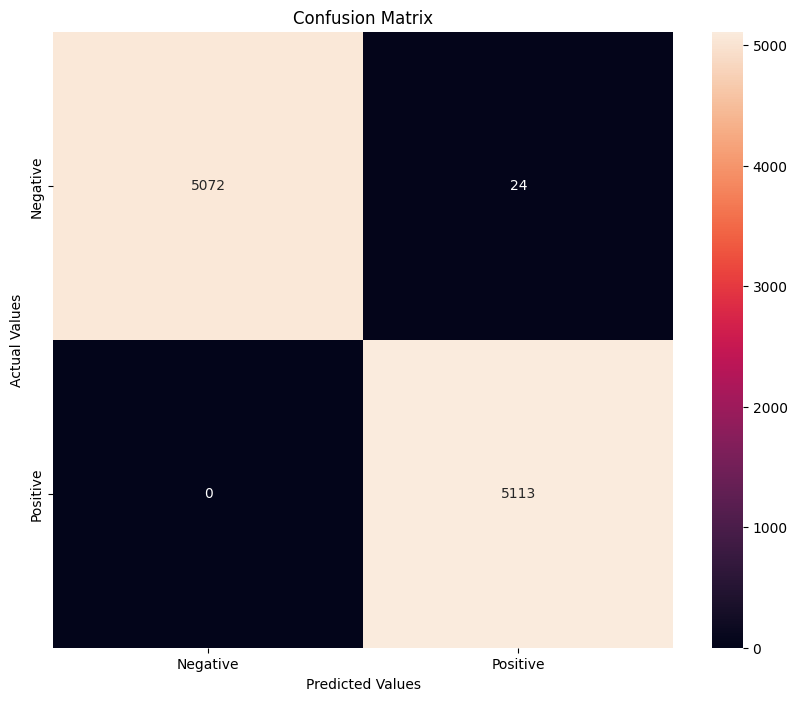

In [274]:
matrix = confusion_matrix(y_test, y_pred)
matrix = pd.DataFrame(matrix, index=['Negative', 'Positive'],
                              columns=['Negative', 'Positive'])
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Well, these are obviously the best results so far, by a very large margin. 

However, I think we can perfect this, by altering the number of samples in the dataset. Right now, there are roughly 17k positives and negatives in the dataset, because of the oversampling that was done, but I believe that this could be too many, since many of the rows included in the test set are likely duplicates that it already saw in the training set.

#### Stack with SMOTE

In [283]:
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [284]:
rfResample.fit(X_train_smote, y_train_smote)
y_pred = rfResample.predict(X_test)

rfResample2Results = saveTestResults(rfResample, y_pred, y_test, resultsDict2, "RandomForest Resample2", isTrain=False)
rfResample2Results

,Precision,Recall,F1 Score,Accuracy
0,0.995561,1.0,0.997775,0.997767


#### Stack with Threshold

In [285]:
optimalResample = getBestThreshold(rfResample, X_test, y_test, resultsDict2, "RandomForest")
optimalResample

{'Precision': (1.0, 0.99),
 'Recall': (1.0, 0.99),
 'F1 Score': (1.0, 0.99),
 'Accuracy': (1.0, 0.99)}

Obviously, the threshold is optimal at 0.99

In [286]:
baseProb = rfResample.predict_proba(X_test)[:, 1]
threshold = 0.99
customPred = (baseProb >= threshold).astype(int)

finalThreshResults = saveTestResults(rfResample, customPred, y_test, resultsDict2, "RandomForest Perfect", isTrain=False)
finalThreshResults

,Precision,Recall,F1 Score,Accuracy
0,1.0,1.0,1.0,1.0


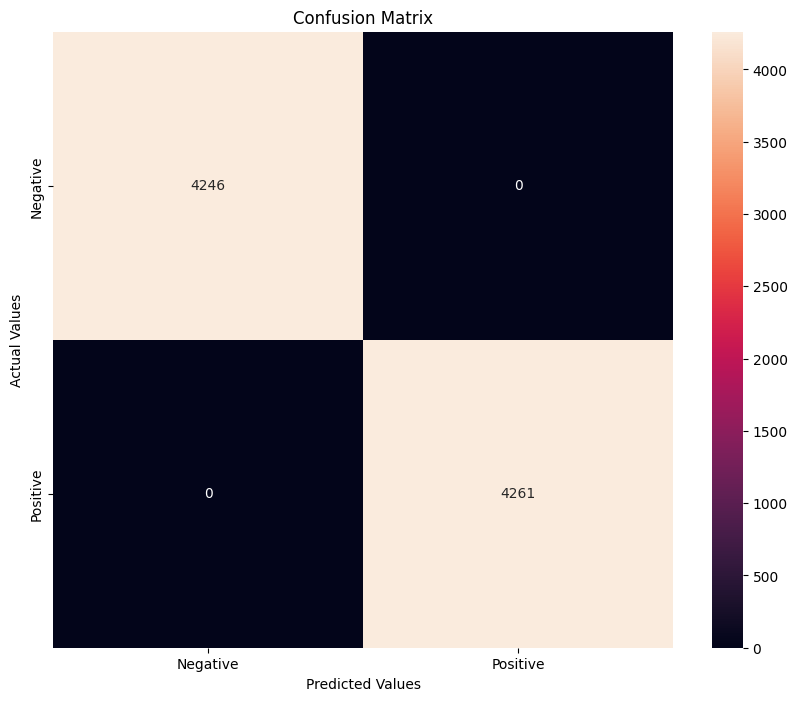

In [291]:
matrix = confusion_matrix(y_test, customPred)
matrix = pd.DataFrame(matrix, index=['Negative', 'Positive'],
                              columns=['Negative', 'Positive'])
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## **Final Thoughts**

So, now that I am finally satisfied, by seeing the highest possible numbers in all metrics, there are a few thoughts that I have on this.

Firstly, it took a lot of work to get to this point, and even more research. Originally, I was optimizing only the models themselves, and achieved a relatively high success rate in doing so. If I continued in this direction, and put more work into the gradient booster, I think that I could have achieved close to 0.9 F1, without making any extra changes to the dataset. 

Secondly, despite the amount of time and effort that I put into making the model output perfect results, I don't think that this is remotely usable in a practical environment. In fact, I actually think that these results are almost entirely fraudulent, simply because of the amount of resampling that needed to be done, in order to achieve these types of results. Not only did I oversample the minority, I did so to a degree of ~19, meaning there are literally ~19 copies of each negative row in the dataset. This just means that, when the model encounters these same rows in test, it remembers seeing them already (likely several times), and knows how to classify them. 

Thirdly, not only was the minority heavily oversampled, the resampled data was also stacked with a custom prediction threshold, which was optimized at 0.99. This just means that the model will only make a classification when it is nearly 100% confident that it will be correct. In most cases, this would be detrimental to the results, however, it isn't in this case, because all of the negative results are heavily duplicated. So, if I were to take a guess here, I would say that it only makes predictions on those that it has seen before.

Finally, I knew all of this would be the case before embarking on the quest for "perfect" results, but did so anyways, just to prove that I could. However, if I had to take one of these iterations with me to use in the real world, it would likely be iteration 1. The main reason for this is that those models can achieve between 0.8-0.9 F1 without any resampling at all, and the experimenting that was done on them was done with the purpose of practicality, rather than simply seeing a high number in the results, which is what I did in the final iteration.